## Exploratory Data Analysis and Feature Engineering
<h4>Team Twin AI</h4>
<h4><b>Overview</b></h4>

This is the EDA and Feature Egineering component of our solution to the FormulaAI Hack 2022 Competition. The workflow for this notebook is outlined as follows: 
- Multivariate Exploratory Analysis
- Feature Importance and Selection

## Learning to Forecast
<h4>Team Twin AI</h4>
<h4><b>Overview</b></h4>

This is the Machine Learning component of our solution to the FormulaAI Hack 2022 Competition. The workflow for this notebook is outlined as follows:
- Model Experimentations I: Classification
- Model Experimentations II: Regression
- Evaluation and Predictions

In [1]:

import os

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100)


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
#sns.set_style('whitegrid')
#sns.set_palette('Blues_r')

import deepchecks as dc
from deepchecks.checks.methodology import SingleFeatureContribution
from deepchecks.base import Dataset

#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.preprocessing import scale,StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats

import random
import time
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('cleaned_one.csv')
data.head()

Unnamed: 0  M_SESSION_UID  M_SESSION_TIME  M_FRAME_IDENTIFIER  \
0           0   2.939734e+18          65.276                1647   
1           1   2.939734e+18          65.276                1647   
2           2   2.939734e+18          65.276                1647   
3           3   2.939734e+18          65.276                1647   
4           4   2.939734e+18          65.276                1647   

   M_PLAYER_CAR_INDEX  M_BRAKING_ASSIST  M_SESSION_LINK_IDENTIFIER  \
0                   0                 0                 1553478724   
1                   0                 0                 1553478724   
2                   0                 0                 1553478724   
3                   0                 0                 1553478724   
4                   0                 0                 1553478724   

   M_PIT_RELEASE_ASSIST  M_PIT_STOP_WINDOW_IDEAL_LAP  M_TRACK_TEMPERATURE  \
0                     0                            0                   33   
1                     0                            0                   33   
2                     0                            0                   33   
3                     0                            0                   33   
4                     0                            0                   33   

   M_TRACK_LENGTH  M_FORECAST_ACCURACY  M_AIR_TEMPERATURE  \
0            4650                    0                 25   
1            4650                    0                 25   
2            4650                    0                 25   
3            4650                    0                 25   
4            4650                    0                 25   

   M_NUM_WEATHER_FORECAST_SAMPLES  M_TRACK_ID  M_ERSASSIST  M_FORMULA  \
0                              10          28            0          0   
1                              10          28            0          0   
2                              10          28            0          0   
3                              10          28            0          0   
4                              10          28            0          0   

   M_SEASON_LINK_IDENTIFIER  M_PIT_ASSIST  M_GEARBOX_ASSIST  M_SESSION_TYPE  \
0                1553478724             0                 1               8   
1                1553478724             0                 1               8   
2                1553478724             0                 1               8   
3                1553478724             0                 1               8   
4                1553478724             0                 1               8   

   M_PIT_STOP_WINDOW_LATEST_LAP  M_WEEKEND_LINK_IDENTIFIER  \
0                             0                 1553478724   
1                             0                 1553478724   
2                             0                 1553478724   
3                             0                 1553478724   
4                             0                 1553478724   

   M_DYNAMIC_RACING_LINE_TYPE  M_PIT_STOP_REJOIN_POSITION  M_TIME_OFFSET  \
0                           0                           0            0.0   
1                           0                           0            5.0   
2                           0                           0           10.0   
3                           0                           0            0.0   
4                           0                           0            5.0   

   M_WEATHER_FORECAST_SAMPLES_M_WEATHER  M_TRACK_TEMPERATURE_CHANGE  \
0                                   0.0                         2.0   
1                                   0.0                         2.0   
2                                   0.0                         2.0   
3                                   1.0                         1.0   
4                                   1.0                         2.0   

   M_AIR_TEMPERATURE_CHANGE  M_RAIN_PERCENTAGE  M_WEATHER  M_AI_DIFFICULTY  \
0                       2.0                1.0          0               31   
1               

In [3]:
data.drop('Unnamed: 0', axis =1, inplace = True)

In [4]:
df = data.copy()
print(df.shape)
df.isna().values.any()

(1957078, 39)


False

<br>
<h4><b>1. Multivariate Exploratory Analysis</b></h4>
<p> Our first step is to visualise and understand the correlation that exists between the features in the data

<AxesSubplot:>

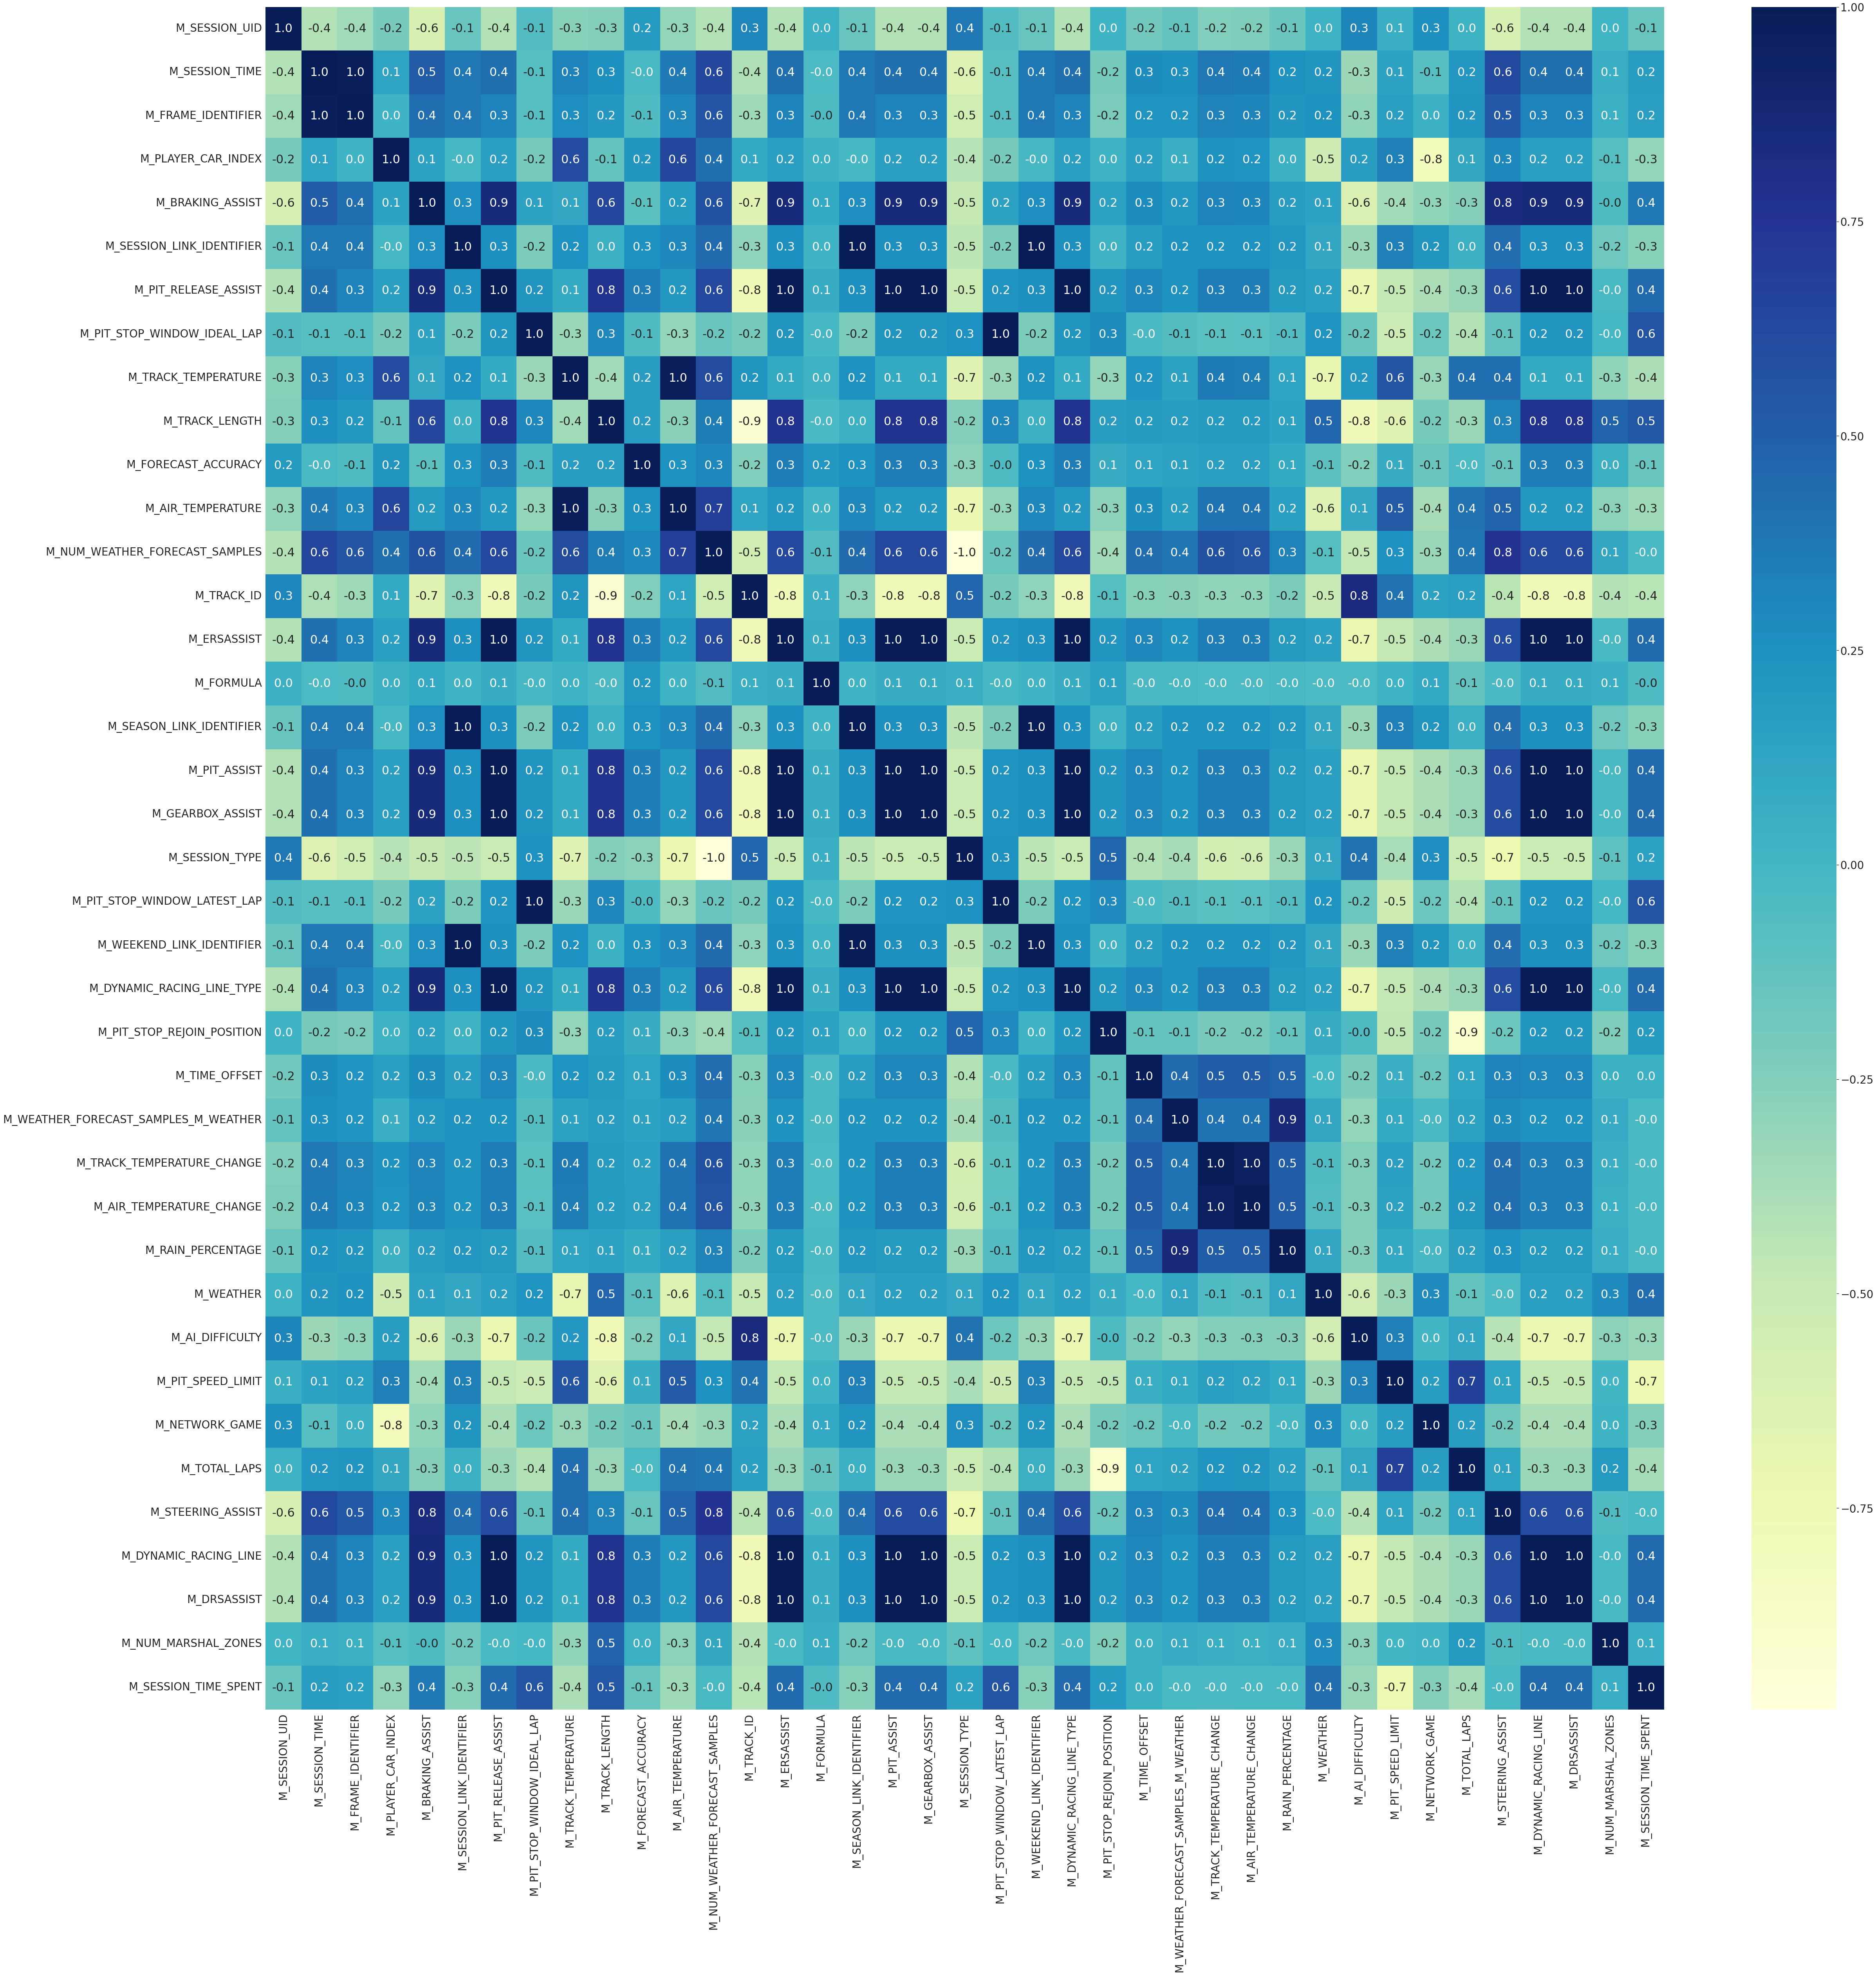

In [5]:
corrmat = df.corr()
#f, ax = plt.subplots(figsize=(16, 12))
#sns.heatmap(corrmat, vmax=.8, annot=True, square=True, fmt='.2f')

plt.figure(figsize=(80,80))
sns.set(font_scale=2.5)
sns.heatmap(corrmat, annot=True, fmt='.1f', cmap='YlGnBu')

The above plot is too clustered, so let's zoom in to the tope 20 most correlated features

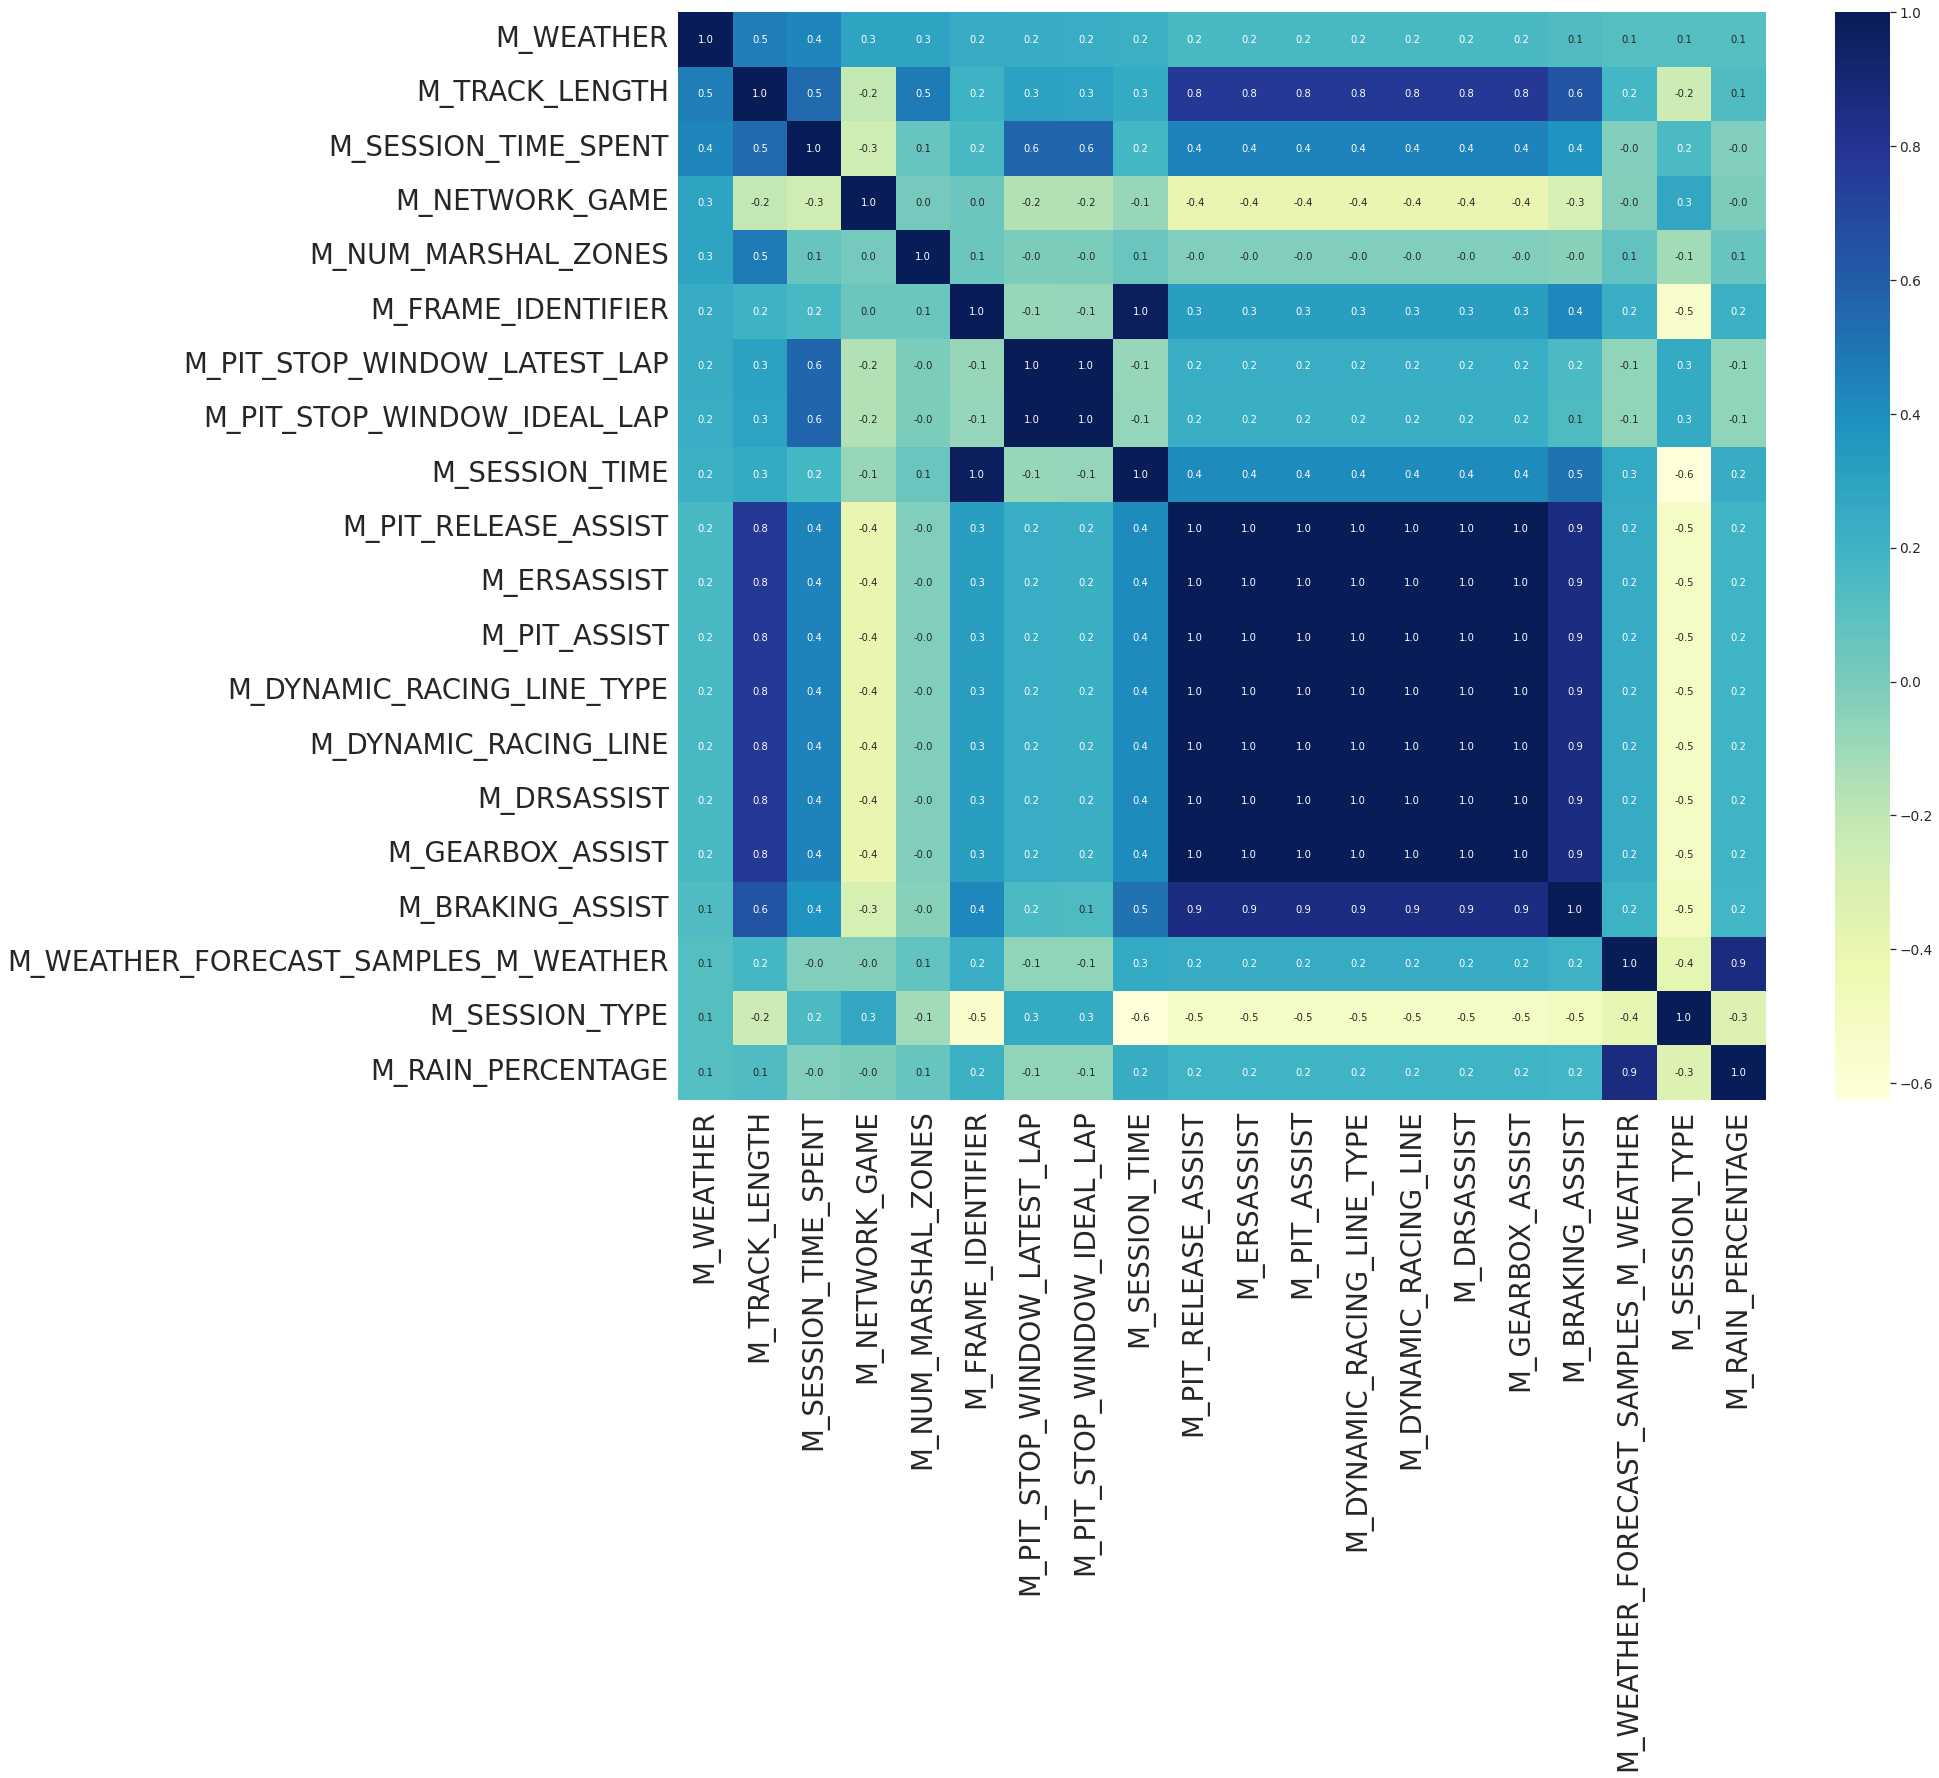

In [6]:
#### top 20 most correlated features with Weather (correlation matrix) 

f, ax = plt.subplots(figsize=(25,20))
k = 20 #number of variables for heatmap
cols = df.corr().nlargest(k, 'M_WEATHER')['M_WEATHER'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', cmap='YlGnBu', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

If we zoom further in to the above plot, we find that M_WEEKEND_LINK_IDENTIFIER, M_SEASON_LINK_IDENTIFIER and M_SESSION_LINK_IDENTIFIER show
perfect correleration of 1.

In [7]:
xtremilar_col = ['M_WEEKEND_LINK_IDENTIFIER', 'M_SEASON_LINK_IDENTIFIER', 'M_SESSION_LINK_IDENTIFIER']

<AxesSubplot:>

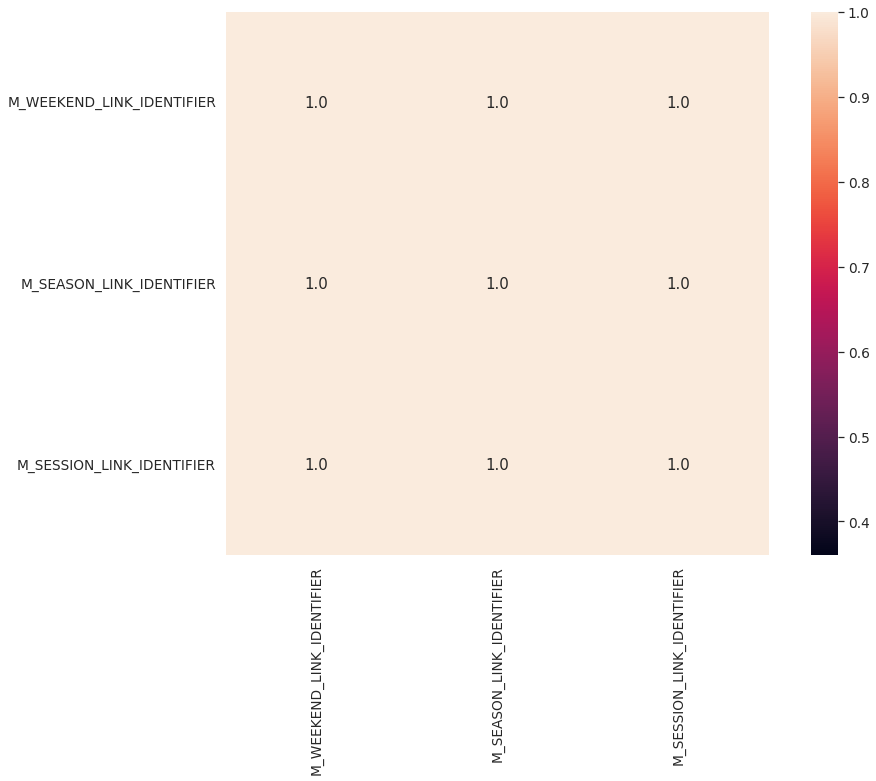

In [8]:
corrmat = df[xtremilar_col ].corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.4, annot=True, square=True, fmt='.1f',)

In [9]:
for col in xtremilar_col:
    print(col,'-->',df[col].nunique())

M_WEEKEND_LINK_IDENTIFIER --> 37
M_SEASON_LINK_IDENTIFIER --> 32
M_SESSION_LINK_IDENTIFIER --> 49


<br>For the heatmap to have indicated a correlation of 1.0, then it means one or 2 columns will most likely contain all of the values in others. We will perform a groupby on each of them to identify how many unique values in one column correspond to each unique value in another column.

In [10]:
df[xtremilar_col].groupby('M_WEEKEND_LINK_IDENTIFIER').nunique()

M_SEASON_LINK_IDENTIFIER  M_SESSION_LINK_IDENTIFIER
M_WEEKEND_LINK_IDENTIFIER                                                     
861334657                                         1                          1
1110683812                                        1                          1
1484504721                                        1                          1
1553478724                                        1                          1
1563223907                                        1                          1
1618716359                                        1                          1
1835625305                                        1                          2
1951222531                                        1                          2
1951222631                                        1                          2
1951222731                                        1                          2
1951222831                                        1                          1
2121613153                                        1                          1
2147180855                                        1                          1
2179439779                                        1                          2
2184232491                                        1                          2
2585742948                                        1                          1
2684478162                                        1                          1
2756721461                                        1                          2
2763502765                                        1                          1
2842617962                                        1                          1
2880781899                                        1                          2
2908583271                                        1                          1
3037248480                                        1                          1
3081081018                                        1                          1
3271241059                                        1                          1
3314973601                                        1                          2
3447124844                                        1                          2
3553396220                                        1                          1
3555771081                                        1                          1
3589936465                                        1                          1
3605912076                                        1                          1
3846328331                                        1                          2
4115554664                                        1                          1
4155675678                                        1                          1
4155675778                                        1                          2
4155675878                                        1                          1
4264308897                                        1                          1

In [11]:
df[xtremilar_col].groupby('M_SEASON_LINK_IDENTIFIER').nunique()

M_WEEKEND_LINK_IDENTIFIER  M_SESSION_LINK_IDENTIFIER
M_SEASON_LINK_IDENTIFIER                                                      
861334657                                         1                          1
1110683812                                        1                          1
1484504721                                        1                          1
1553478724                                        1                          1
1563223907                                        1                          1
1618716359                                        1                          1
1835625305                                        1                          2
1951222531                                        4                          7
2121613153                                        1                          1
2147179955                                        1                          1
2179439779                                        1                          2
2184232491                                        1                          2
2585742948                                        1                          1
2684478162                                        1                          1
2756721461                                        1                          2
2763502765                                        1                          1
2842617962                                        1                          1
2880781899                                        1                          2
2908583271                                        1                          1
3037248480                                        1                          1
3081081018                                        1                          1
3271241059                                        1                          1
3314973601                                        1                          2
3447124844                                        1                          2
3553396220                                        1                          1
3555771081                                        1                          1
3589936465                                        1                          1
3605912076                                        1                          1
3846328331                                        1                          2
4115554664                                        1                          1
4155674778                                        3                          4
4264308897                                        1                          1

In [12]:
df[xtremilar_col].groupby('M_SESSION_LINK_IDENTIFIER').nunique()

M_WEEKEND_LINK_IDENTIFIER  M_SEASON_LINK_IDENTIFIER
M_SESSION_LINK_IDENTIFIER                                                     
861334657                                          1                         1
1110683812                                         1                         1
1484504761                                         1                         1
1553478724                                         1                         1
1563223907                                         1                         1
1618716359                                         1                         1
1835625305                                         1                         1
1835625315                                         1                         1
1951222561                                         1                         1
1951222591                                         1                         1
1951222661                                         1                         1
1951222691                                         1                         1
1951222731                                         1                         1
1951222791                                         1                         1
1951222831                                         1                         1
2121613153                                         1                         1
2147180865                                         1                         1
2179439779                                         1                         1
2179439789                                         1                         1
2184232491                                         1                         1
2184232501                                         1                         1
2585742948                                         1                         1
2684478162                                         1                         1
2756721461                                         1                         1
2756721471                                         1                         1
2763502775                                         1                         1
2842617962                                         1                         1
2880781899                                         1                         1
2880781909                                         1                         1
2908583271                                         1                         1
3037248480                                         1                         1
3081081018                                         1                         1
3271241059                                         1                         1
3314973601                                         1                         1
3314973611                                         1                         1
3447124844                                         1                         1
3447124854                                         1                         1
3553396220                                         1                         1
3555771081                                         1                         1
3589936465                                         1                         1
3605912076                                         1                         1
3846328331                                         1                         1
3846328341                                         1                         1
4115554664                                         1                         1
4155675688                                         1                         1
4155675778                                         1                         1
4155675788                                         1                         1
4155675888                                         1                         1
4264308897                                         1                         

From the first result, we find that only the season link ID occurs exactly once in the weekend ID groups. However, the second result shows that the weekend ID occurs more than once in some season ID groups. Therefore, weekend ID is a superset of season ID, indicating that weekend ID captures all the information that weekend ID presents. 

Finally, we see that in the third result, both season ID and weekend ID occur exactly once in the session ID group, indicating that session ID captures all the informations that both season ID and weekend ID presents. This makes sense considering that whether the games are played in a weekend, a season, or otherwise, each game is played in session. This provides the justification for which we will be dropping both the season and weekend IDs.

In [13]:
df.drop(xtremilar_col[:-1], axis=1, inplace=True)
print(df.shape)

(1957078, 37)


Now, we zoom into the correlation submatrix containing five of the seven assist features and the dynamic racing line features, which all showed perfect correleration of 1 within the block. Our assumption is that the other two assists features that do not make it to this block, namely steering assist and braking assist, could be due to a much smaller proportion of players using these assists, as more players typically have experience to play without these 2 supports. 

In [14]:
xtremilar_col2 = [
'M_DYNAMIC_RACING_LINE_TYPE'
,'M_DYNAMIC_RACING_LINE'
,'M_PIT_RELEASE_ASSIST'
,'M_ERSASSIST'
,'M_PIT_ASSIST'
,'M_GEARBOX_ASSIST'
,'M_STEERING_ASSIST'
,'M_BRAKING_ASSIST'
,'M_DRSASSIST']

<AxesSubplot:>

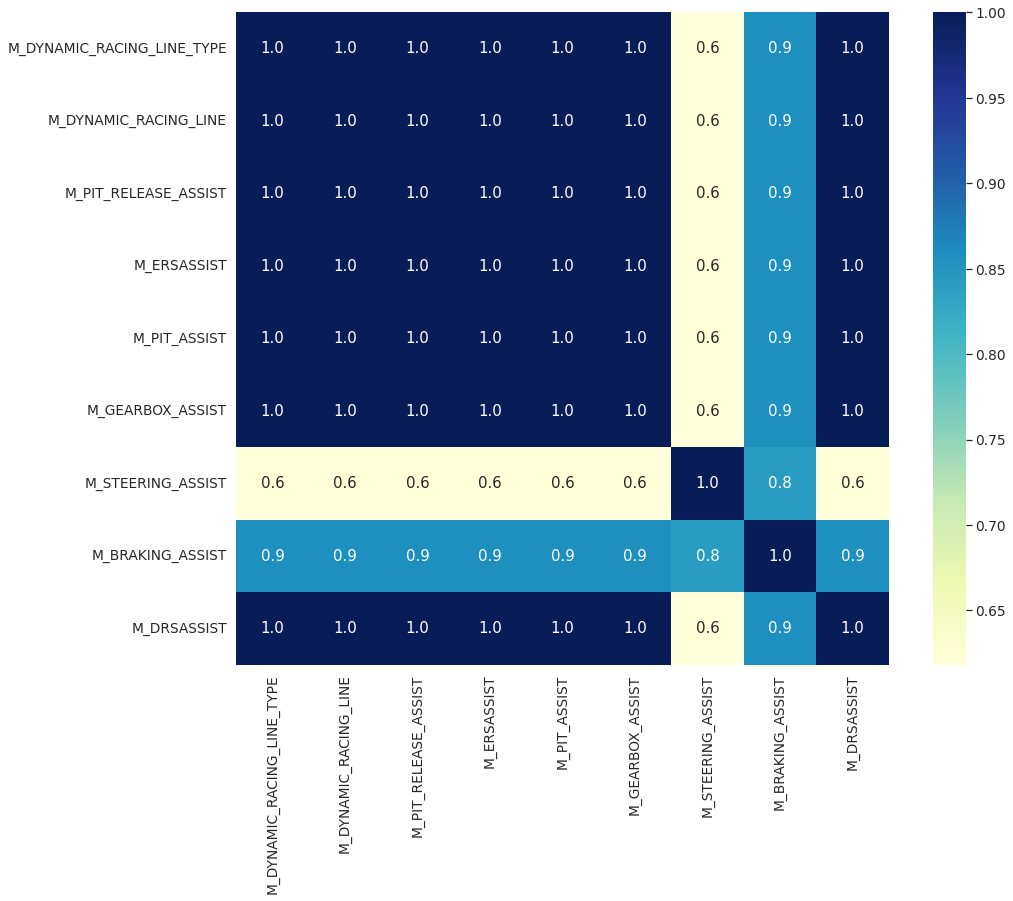

In [15]:
corrmat2 = df[xtremilar_col2].corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat2, vmax=1, annot=True, square=True, fmt='.1f', cmap='YlGnBu')

Now we begin by performing a groupby on the columns in the list, one column at a time

In [16]:
df[xtremilar_col2].groupby('M_DYNAMIC_RACING_LINE_TYPE').nunique()

M_DYNAMIC_RACING_LINE  M_PIT_RELEASE_ASSIST  \
M_DYNAMIC_RACING_LINE_TYPE                                                
0                                               1                     1   
1                                               1                     1   

                            M_ERSASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_DYNAMIC_RACING_LINE_TYPE                                                
0                                     1             1                 1   
1                                     1             1                 1   

                            M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_DYNAMIC_RACING_LINE_TYPE                                                    
0                                           1                 1            1  
1                                           2                 3            1

In [17]:
df[xtremilar_col2].groupby('M_DYNAMIC_RACING_LINE').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_PIT_RELEASE_ASSIST  \
M_DYNAMIC_RACING_LINE                                                     
0.0                                             1                     1   
2.0                                             1                     1   

                       M_ERSASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_DYNAMIC_RACING_LINE                                                
0.0                              1             1                 1   
2.0                              1             1                 1   

                       M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_DYNAMIC_RACING_LINE                                                    
0.0                                    1                 1            1  
2.0                                    2                 3            1

In [18]:
df[xtremilar_col2].groupby('M_ERSASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_ERSASSIST                                                      
0                                     1                      1   
1                                     1                      1   

             M_PIT_RELEASE_ASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_ERSASSIST                                                         
0                               1             1                 1   
1                               1             1                 1   

             M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_ERSASSIST                                                    
0                            1                 1            1  
1                            2                 3            1

In [19]:
df[xtremilar_col2].groupby('M_PIT_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_PIT_ASSIST                                                      
0                                      1                      1   
1                                      1                      1   

              M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_GEARBOX_ASSIST  \
M_PIT_ASSIST                                                        
0                                1            1                 1   
1                                1            1                 1   

              M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_PIT_ASSIST                                                    
0                             1                 1            1  
1                             2                 3            1

In [20]:
df[xtremilar_col2].groupby('M_GEARBOX_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_GEARBOX_ASSIST                                                      
1                                          1                      1   
3                                          1                      1   

                  M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_GEARBOX_ASSIST                                                    
1                                    1            1             1   
3                                    1            1             1   

                  M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_GEARBOX_ASSIST                                                    
1                                 1                 1            1  
3                                 2                 3            1

In [21]:
df[xtremilar_col2].groupby('M_STEERING_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_STEERING_ASSIST                                                      
0.0                                         2                      2   
1.0                                         1                      1   

                   M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_STEERING_ASSIST                                                    
0.0                                   2            2             2   
1.0                                   1            1             1   

                   M_GEARBOX_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_STEERING_ASSIST                                                   
0.0                               2                 3            2  
1.0                               1                 1            1

In [22]:
df[xtremilar_col2].groupby('M_BRAKING_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_BRAKING_ASSIST                                                      
0                                          2                      2   
2                                          1                      1   
3                                          1                      1   

                  M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_BRAKING_ASSIST                                                    
0                                    2            2             2   
2                                    1            1             1   
3                                    1            1             1   

                  M_GEARBOX_ASSIST  M_STEERING_ASSIST  M_DRSASSIST  
M_BRAKING_ASSIST                                                    
0                                2                  1            2  
2                                1                  1            1  
3                                1                  2            1

In [23]:
df[xtremilar_col2].groupby('M_PIT_RELEASE_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_PIT_RELEASE_ASSIST                                                      
0                                              1                      1   
1                                              1                      1   

                      M_ERSASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_PIT_RELEASE_ASSIST                                                
0                               1             1                 1   
1                               1             1                 1   

                      M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_PIT_RELEASE_ASSIST                                                    
0                                     1                 1            1  
1                                     2                 3            1

In [24]:
df[xtremilar_col2].groupby('M_DRSASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_DRSASSIST                                                      
0.0                                   1                      1   
1.0                                   1                      1   

             M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_DRSASSIST                                                    
0.0                             1            1             1   
1.0                             1            1             1   

             M_GEARBOX_ASSIST  M_STEERING_ASSIST  M_BRAKING_ASSIST  
M_DRSASSIST                                                         
0.0                         1                  1                 1  
1.0                         1                  2                 3

It's a litlle challenging deciding which of the 9 columns to retain, considering that none of the grouby results shows columns having values uniquely occuring once across the groups. An even more important question is whether we need any of these features to predict the targets. We will therefore implement a feature contribution assessment to evaluate which of the 9 (if any) have the highest predictive power score with respect to the targets.

In [26]:
_ = Dataset(df[xtremilar_col2], label=df['M_WEATHER'])
SingleFeatureContribution().run(_)

Some columns have been inferred as categorical features: M_DYNAMIC_RACING_LINE_TYPE, M_DYNAMIC_RACING_LINE, M_PIT_RELEASE_ASSIST, M_ERSASSIST, M_PIT_ASSIST, M_GEARBOX_ASSIST, M_STEERING_ASSIST. 
 and more... 
 For the full list of columns, use dataset.cat_features


Single Feature Contribution Return the PPS (Predictive Power Score) of all features in relation to the label. Read More... Additional Outputs ✓ Nothing found

In [27]:
_ = Dataset(df[xtremilar_col2], label=df['M_RAIN_PERCENTAGE'])
SingleFeatureContribution().run(_)

Some columns have been inferred as categorical features: M_DYNAMIC_RACING_LINE_TYPE, M_DYNAMIC_RACING_LINE, M_PIT_RELEASE_ASSIST, M_ERSASSIST, M_PIT_ASSIST, M_GEARBOX_ASSIST, M_STEERING_ASSIST. 
 and more... 
 For the full list of columns, use dataset.cat_features


Single Feature Contribution Return the PPS (Predictive Power Score) of all features in relation to the label. Read More... Additional Outputs ✓ Nothing found

We will just drop all the 9 features

In [25]:
df.drop(xtremilar_col2, axis=1, inplace=True)
print(df.shape)
df.head()

(1957078, 28)


M_SESSION_UID  M_SESSION_TIME  M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  \
0   2.939734e+18          65.276                1647                   0   
1   2.939734e+18          65.276                1647                   0   
2   2.939734e+18          65.276                1647                   0   
3   2.939734e+18          65.276                1647                   0   
4   2.939734e+18          65.276                1647                   0   

   M_SESSION_LINK_IDENTIFIER  M_PIT_STOP_WINDOW_IDEAL_LAP  \
0                 1553478724                            0   
1                 1553478724                            0   
2                 1553478724                            0   
3                 1553478724                            0   
4                 1553478724                            0   

   M_TRACK_TEMPERATURE  M_TRACK_LENGTH  M_FORECAST_ACCURACY  \
0                   33            4650                    0   
1                   33            4650                    0   
2                   33            4650                    0   
3                   33            4650                    0   
4                   33            4650                    0   

   M_AIR_TEMPERATURE  M_NUM_WEATHER_FORECAST_SAMPLES  M_TRACK_ID  M_FORMULA  \
0                 25                              10          28          0   
1                 25                              10          28          0   
2                 25                              10          28          0   
3                 25                              10          28          0   
4                 25                              10          28          0   

   M_SESSION_TYPE  M_PIT_STOP_WINDOW_LATEST_LAP  M_PIT_STOP_REJOIN_POSITION  \
0               8                             0                           0   
1               8                             0                           0   
2               8                             0                           0   
3               8                             0                           0   
4               8                             0                           0   

   M_TIME_OFFSET  M_WEATHER_FORECAST_SAMPLES_M_WEATHER  \
0            0.0                                   0.0   
1            5.0                                   0.0   
2           10.0                                   0.0   
3            0.0                                   1.0   
4            5.0                                   1.0   

   M_TRACK_TEMPERATURE_CHANGE  M_AIR_TEMPERATURE_CHANGE  M_RAIN_PERCENTAGE  \
0                         2.0                       2.0                1.0   
1                         2.0                       2.0                1.0   
2                         2.0                       2.0                2.0   
3                         1.0                       1.0                5.0   
4                         2.0                       2.0                5.0   

   M_WEATHER  M_AI_DIFFICULTY  M_PIT_SPEED_LIMIT  M_NETWORK_GAME  \
0          0               31                 80             1.0   
1          0               31                 80             1.0   
2          0               31                 80             1.0   
3          0               31                 80             1.0   
4          0               31                 80             1.0   

   M_TOTAL_LAPS  M_NUM_MARSHAL_ZONES  M_SESSION_TIME_SPENT  
0         200.0                 16.0                    61  
1         200.0                 16.0                    61  
2         200.0                 16.0                    61  
3         200.0                 16.0                    61  
4         200.0                 16.0                    61

The above contribution checks showed us that we do not need any of the 9 features for our model. We will apply such an assessment on the rest of our features during feature selection. For now, we want to explore the groupings in the data.

<br><b> Exploring the groupings in the data</b>

In [26]:
de = df.copy()

In [33]:
dd = de.groupby(['M_SESSION_UID', 'M_TIME_OFFSET'])
dd.first()

M_SESSION_TIME  M_FRAME_IDENTIFIER  \
M_SESSION_UID M_TIME_OFFSET                                       
2.106082e+16  0.0                    28.860                 624   
              5.0                    28.860                 624   
              10.0                   28.860                 624   
              15.0                   28.860                 624   
              30.0                   28.860                 624   
...                                     ...                 ...   
1.802471e+19  10.0                    0.004                   0   
              15.0                    0.004                   0   
              30.0                    0.004                   0   
              45.0                    0.004                   0   
              60.0                    0.004                   0   

                             M_PLAYER_CAR_INDEX  M_SESSION_LINK_IDENTIFIER  \
M_SESSION_UID M_TIME_OFFSET                                                  
2.106082e+16  0.0                            19                 2184232491   
              5.0                            19                 2184232491   
              10.0                           19                 2184232491   
              15.0                           19                 2184232491   
              30.0                           19                 2184232491   
...                                         ...                        ...   
1.802471e+19  10.0                            0                 3846328341   
              15.0                            0                 3846328341   
              30.0                            0                 3846328341   
              45.0                            0                 3846328341   
              60.0                            0                 3846328341   

                             M_PIT_STOP_WINDOW_IDEAL_LAP  M_TRACK_TEMPERATURE  \
M_SESSION_UID M_TIME_OFFSET                                                     
2.106082e+16  0.0                                      0                   33   
              5.0                                      0                   33   
              10.0                                     0                   33   
              15.0                                     0                   33   
              30.0                                     0                   33   
...                                                  ...                  ...   
1.802471e+19  10.0                                     6                   29   
              15.0                                     6                   29   
              30.0                                     6                   29   
              45.0                                     6                   29   
              60.0                                     6                   29   

                             M_TRACK_LENGTH  M_FORECAST_ACCURACY  \
M_SESSION_UID M_TIME_OFFSET                                        
2.106082e+16  0.0                      4650                    0   
              5.0                      4650                    0   
              10.0                     4650                    0   
              15.0                     4650                    0   
              30.0                     4650                    0   
...                                     ...                  ...   
1.802471e+19  10.0                     5441                    0   
              15.0                     5441                    0   
              30.0                     5441                    0   
              45.0                     5441                    0   
              60.0                     5441                    0   

                             M_AIR_TEMPERATURE  \
M_SESSION_UID M_TIME_OFFSET                      
2.106082e+16  0.0                           25   
              5.0                           25   
   

In [ ]:
plt.figure(figsize=(15, 10))
sns.kdeplot(
   data=df, x="M_WEATHER", hue="M_RAIN_PERCENTAGE",
   fill=True, common_norm=False, palette="coolwarm",
   alpha=.5, linewidth=0,
)
plt.grid(False)

Now, let us explore the distribution of some of the features within the groups of the data, and see how these features change over time, session to session.

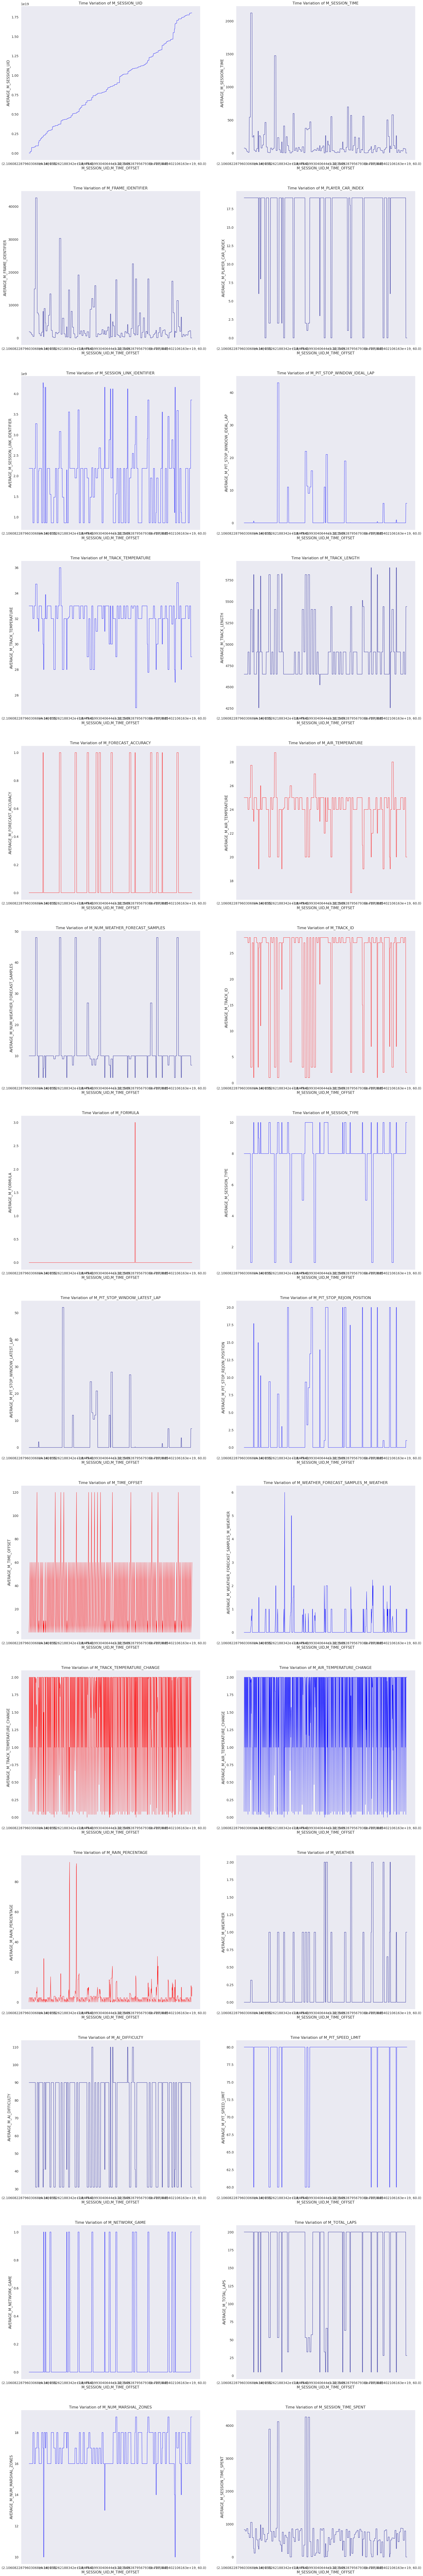

In [42]:
count = 1
colour = ['blue','red','darkblue']
plt.figure(figsize=(30,200))
for col in de.columns:
    plt.subplot(14,2,count)
    dd[col].mean().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('AVERAGE_{}'.format(col)) 
    plt.title('Time Variation of {}'.format(col), fontsize = 16)
    #plt.legend(loc='center')
    plt.grid(False)
    if count<36:
        count+=1

<br>As our ultimate goal is to <b> build models that learn the evolution of in-game weather conditions over time</b> columns that do not show reasonable variation over time, as revealed by the plots, will be less useful for our models. The rest of the columns will pass through an automated feature selection procedure to leave out the best features required for model training.

Before dropping these columns let's transform the data by regrouping by session UID, we then sort by session time and time offset. In order words, we want to find out the time variation, session by session.

In [27]:
start = de.copy()
frames = []
for uid in np.sort(start['M_SESSION_UID'].unique()):
    _ = start[start['M_SESSION_UID']==uid]
    _.sort_values(by=['M_SESSION_TIME','M_TIME_OFFSET'], inplace=True,
               ascending = [True, True])
    frames.append(_)
dtime = pd.concat(frames)
dtime.shape

(1957078, 28)

In [44]:
dtime.head()

M_SESSION_UID  M_SESSION_TIME  M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  \
911512   2.106082e+16           28.86                 624                  19   
911515   2.106082e+16           28.86                 624                  19   
911522   2.106082e+16           28.86                 624                  19   
911523   2.106082e+16           28.86                 624                  19   
911524   2.106082e+16           28.86                 624                  19   

        M_SESSION_LINK_IDENTIFIER  M_PIT_STOP_WINDOW_IDEAL_LAP  \
911512                 2184232491                            0   
911515                 2184232491                            0   
911522                 2184232491                            0   
911523                 2184232491                            0   
911524                 2184232491                            0   

        M_TRACK_TEMPERATURE  M_TRACK_LENGTH  M_FORECAST_ACCURACY  \
911512                   33            4650                    0   
911515                   33            4650                    0   
911522                   33            4650                    0   
911523                   33            4650                    0   
911524                   33            4650                    0   

        M_AIR_TEMPERATURE  M_NUM_WEATHER_FORECAST_SAMPLES  M_TRACK_ID  \
911512                 25                              10          28   
911515                 25                              10          28   
911522                 25                              10          28   
911523                 25                              10          28   
911524                 25                              10          28   

        M_FORMULA  M_SESSION_TYPE  M_PIT_STOP_WINDOW_LATEST_LAP  \
911512          0               8                             0   
911515          0               8                             0   
911522          0               8                             0   
911523          0               8                             0   
911524          0               8                             0   

        M_PIT_STOP_REJOIN_POSITION  M_TIME_OFFSET  \
911512                           0            0.0   
911515                           0            0.0   
911522                           0            0.0   
911523                           0            0.0   
911524                           0            0.0   

        M_WEATHER_FORECAST_SAMPLES_M_WEATHER  M_TRACK_TEMPERATURE_CHANGE  \
911512                                   0.0                         2.0   
911515                                   0.0                         2.0   
911522                                   0.0                         0.0   
911523                                   0.0                         0.0   
911524                                   0.0                         0.0   

        M_AIR_TEMPERATURE_CHANGE  M_RAIN_PERCENTAGE  M_WEATHER  \
911512                       2.0                3.0          0   
911515                       2.0                3.0          0   
911522                       0.0                0.0          0   
911523                       0.0                0.0          0   
911524                       0.0                0.0          0   

        M_AI_DIFFICULTY  M_PIT_SPEED_LIMIT  M_NETWORK_GAME  M_TOTAL_LAPS  \
911512               90                 80             0.0         200.0   
911515               90                 80             0.0         200.0   
911522               90                 80             0.0         200.0   
911523               90                 80             0.0         200.0   
911524               90                 80             0.0         200.0   

        M_NUM_MARSHAL_ZONES  M_SESSION_TIME_SPENT  
911512                 16.0                   788  
911515                 16.0                   788  
911522                 16.0                   788  
911523                 16.0        

In [45]:
dt = dtime.groupby(['M_SESSION_UID', 'M_TIME_OFFSET'])
dt.first()

M_SESSION_TIME  M_FRAME_IDENTIFIER  \
M_SESSION_UID M_TIME_OFFSET                                       
2.106082e+16  0.0                    28.860                 624   
              5.0                    28.860                 624   
              10.0                   28.860                 624   
              15.0                   28.860                 624   
              30.0                   28.860                 624   
...                                     ...                 ...   
1.802471e+19  10.0                    0.004                   0   
              15.0                    0.004                   0   
              30.0                    0.004                   0   
              45.0                    0.004                   0   
              60.0                    0.004                   0   

                             M_PLAYER_CAR_INDEX  M_SESSION_LINK_IDENTIFIER  \
M_SESSION_UID M_TIME_OFFSET                                                  
2.106082e+16  0.0                            19                 2184232491   
              5.0                            19                 2184232491   
              10.0                           19                 2184232491   
              15.0                           19                 2184232491   
              30.0                           19                 2184232491   
...                                         ...                        ...   
1.802471e+19  10.0                            0                 3846328341   
              15.0                            0                 3846328341   
              30.0                            0                 3846328341   
              45.0                            0                 3846328341   
              60.0                            0                 3846328341   

                             M_PIT_STOP_WINDOW_IDEAL_LAP  M_TRACK_TEMPERATURE  \
M_SESSION_UID M_TIME_OFFSET                                                     
2.106082e+16  0.0                                      0                   33   
              5.0                                      0                   33   
              10.0                                     0                   33   
              15.0                                     0                   33   
              30.0                                     0                   33   
...                                                  ...                  ...   
1.802471e+19  10.0                                     6                   29   
              15.0                                     6                   29   
              30.0                                     6                   29   
              45.0                                     6                   29   
              60.0                                     6                   29   

                             M_TRACK_LENGTH  M_FORECAST_ACCURACY  \
M_SESSION_UID M_TIME_OFFSET                                        
2.106082e+16  0.0                      4650                    0   
              5.0                      4650                    0   
              10.0                     4650                    0   
              15.0                     4650                    0   
              30.0                     4650                    0   
...                                     ...                  ...   
1.802471e+19  10.0                     5441                    0   
              15.0                     5441                    0   
              30.0                     5441                    0   
              45.0                     5441                    0   
              60.0                     5441                    0   

                             M_AIR_TEMPERATURE  \
M_SESSION_UID M_TIME_OFFSET                      
2.106082e+16  0.0                           25   
              5.0                           25   
   

In [330]:
de['SESSION_TIMESTAMP'] = pd.to_datetime(de['M_SESSION_TIME'], unit='s')

Let's explore more internal variations by grouping the data by time offset and session timestamp

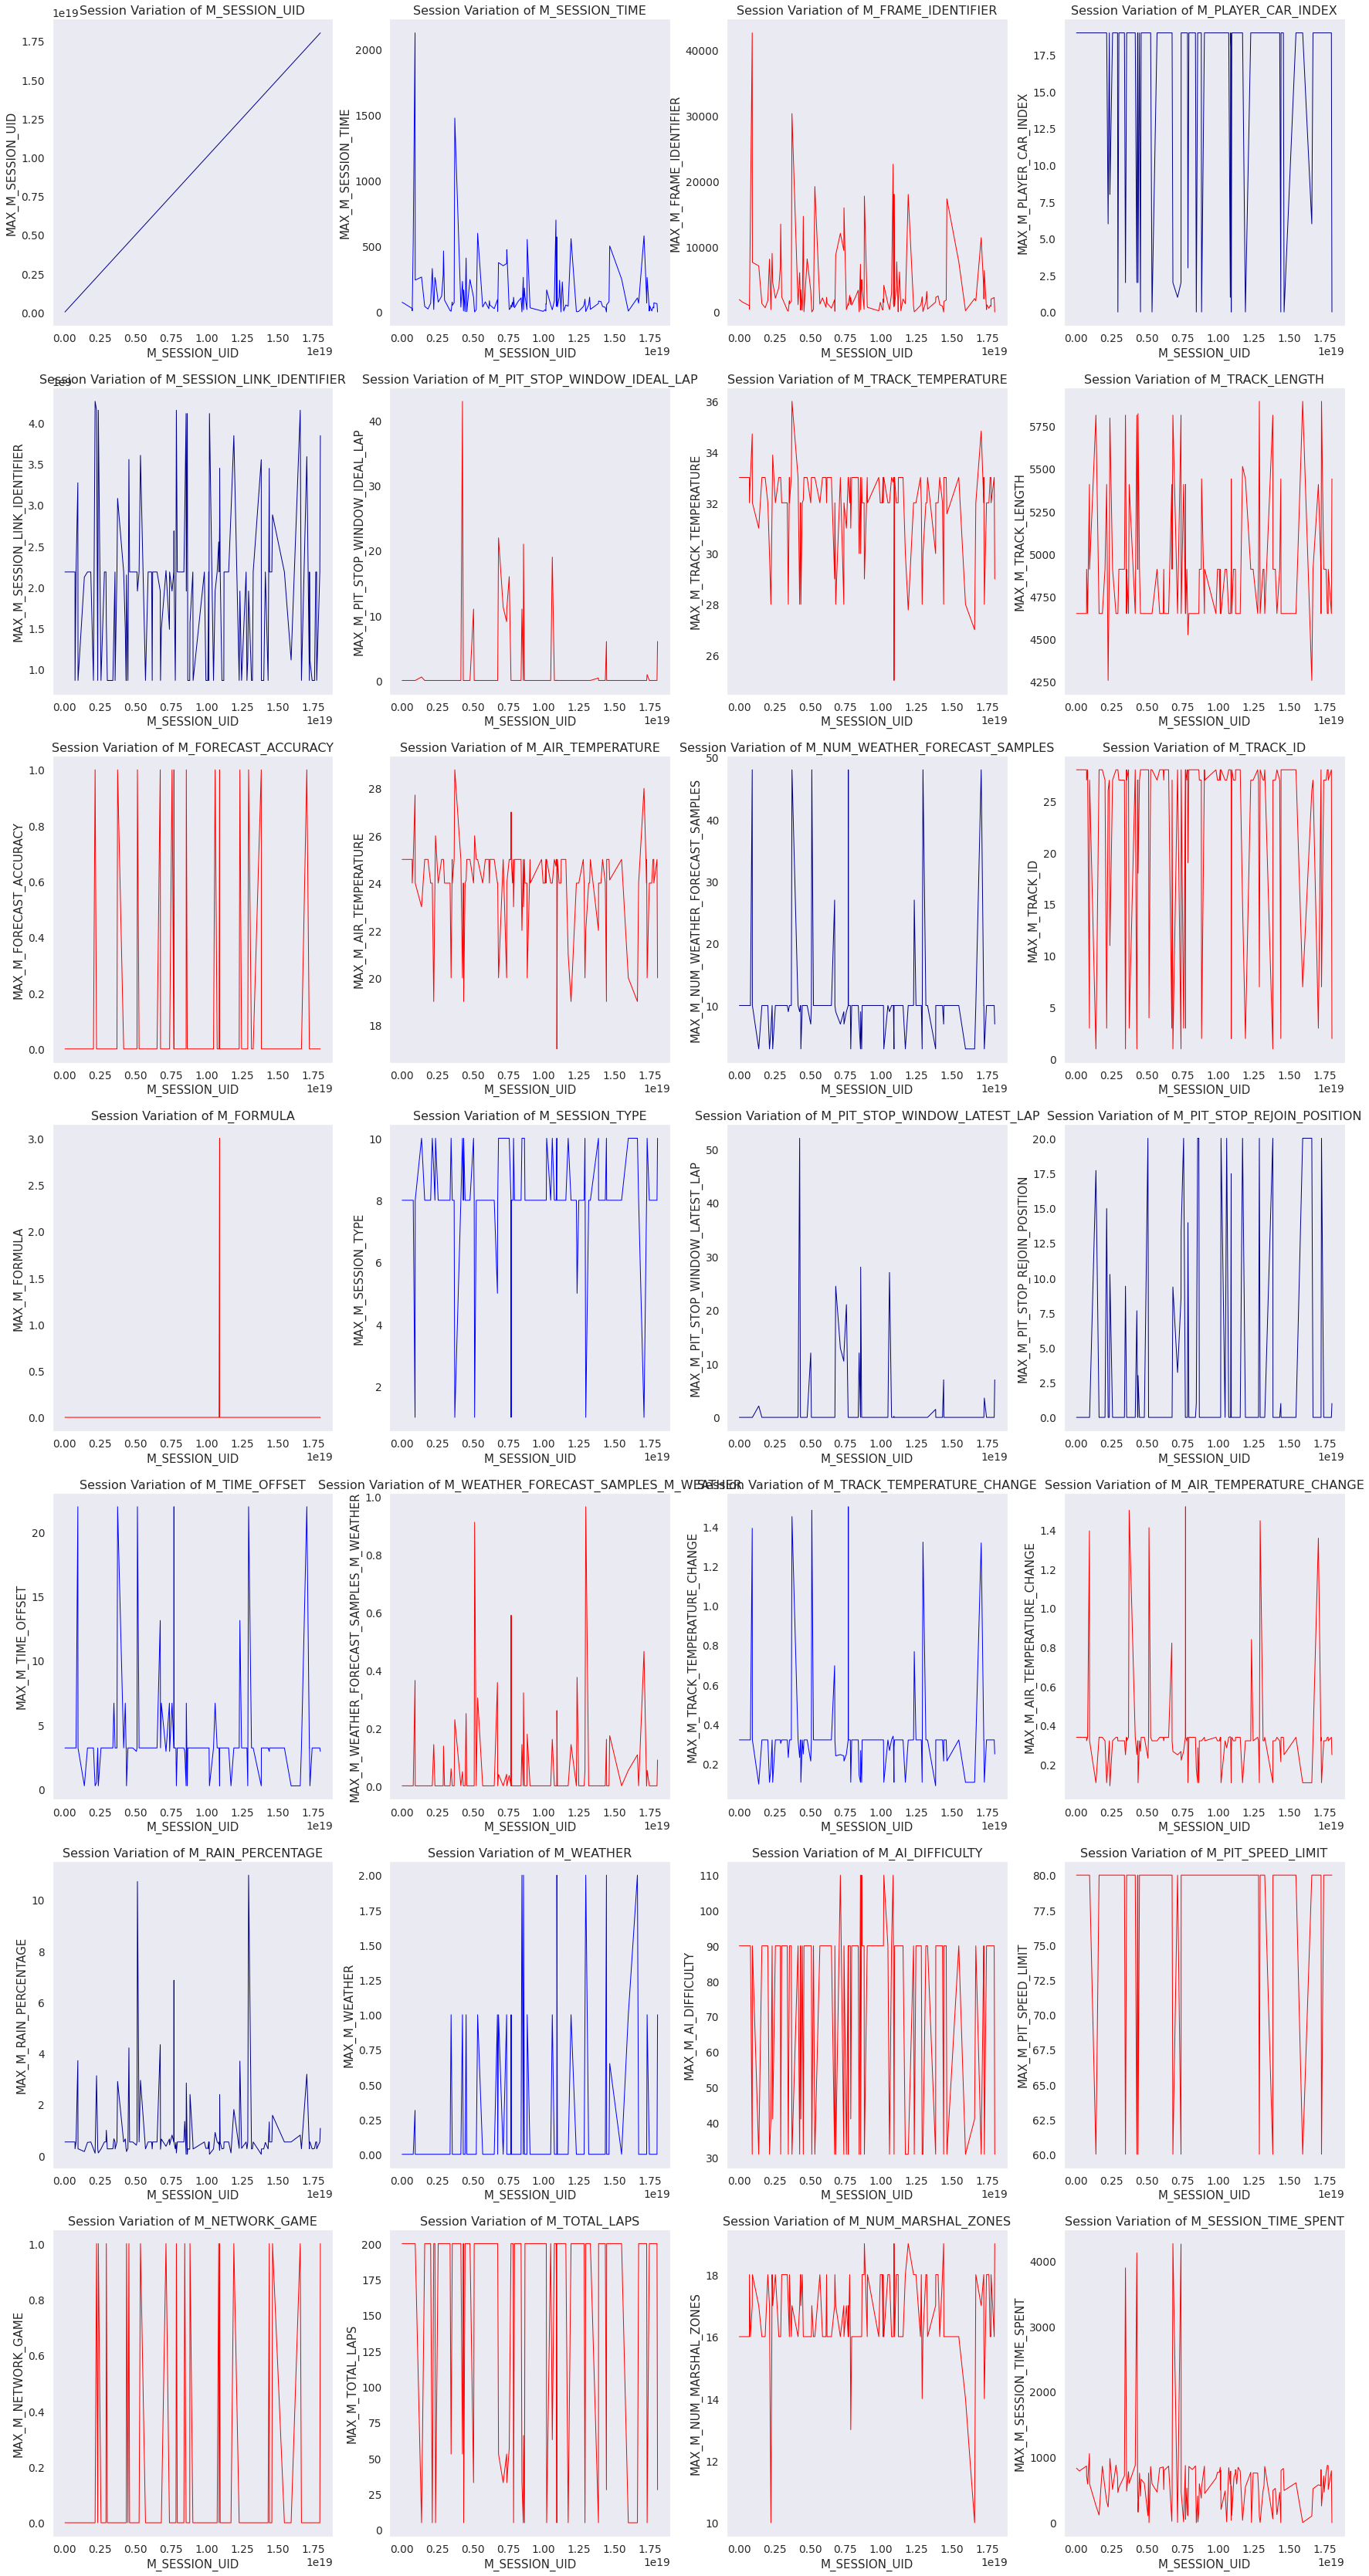

In [50]:
count = 1
colour = ['blue','red','darkblue']
plt.figure(figsize=(30,60))
for col in dtime.columns:
    plt.subplot(7,4,count)
    #dtime.loc[dtime['M_SESSION_UID'].duplicated(),'M_SESSION_UID'].max().plot(color=np.random.choice(colour))
    dtime.groupby('M_SESSION_UID')[col].mean().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('MAX_{}'.format(col)) 
    plt.title('Session Variation of {}'.format(col), fontsize = 16)
    plt.grid(False)
    if count<28:
        count+=1

We see the distributions look almost the same as those of the previous set, which makes sense because we've not changed the data except that we reordered it to look like the previous groupby with session UID and time offset. The key difference between the plot here and the previous one is <b>we plotted the previous one using a groupby object constructed with both session UID and time offset, while in this case we only used session UID</b>. This causes us to lose the additional seasonaility we had previously. 

We will explore this little difference that the time offset feature makes by grouping by time offset alone and exploring the variation.

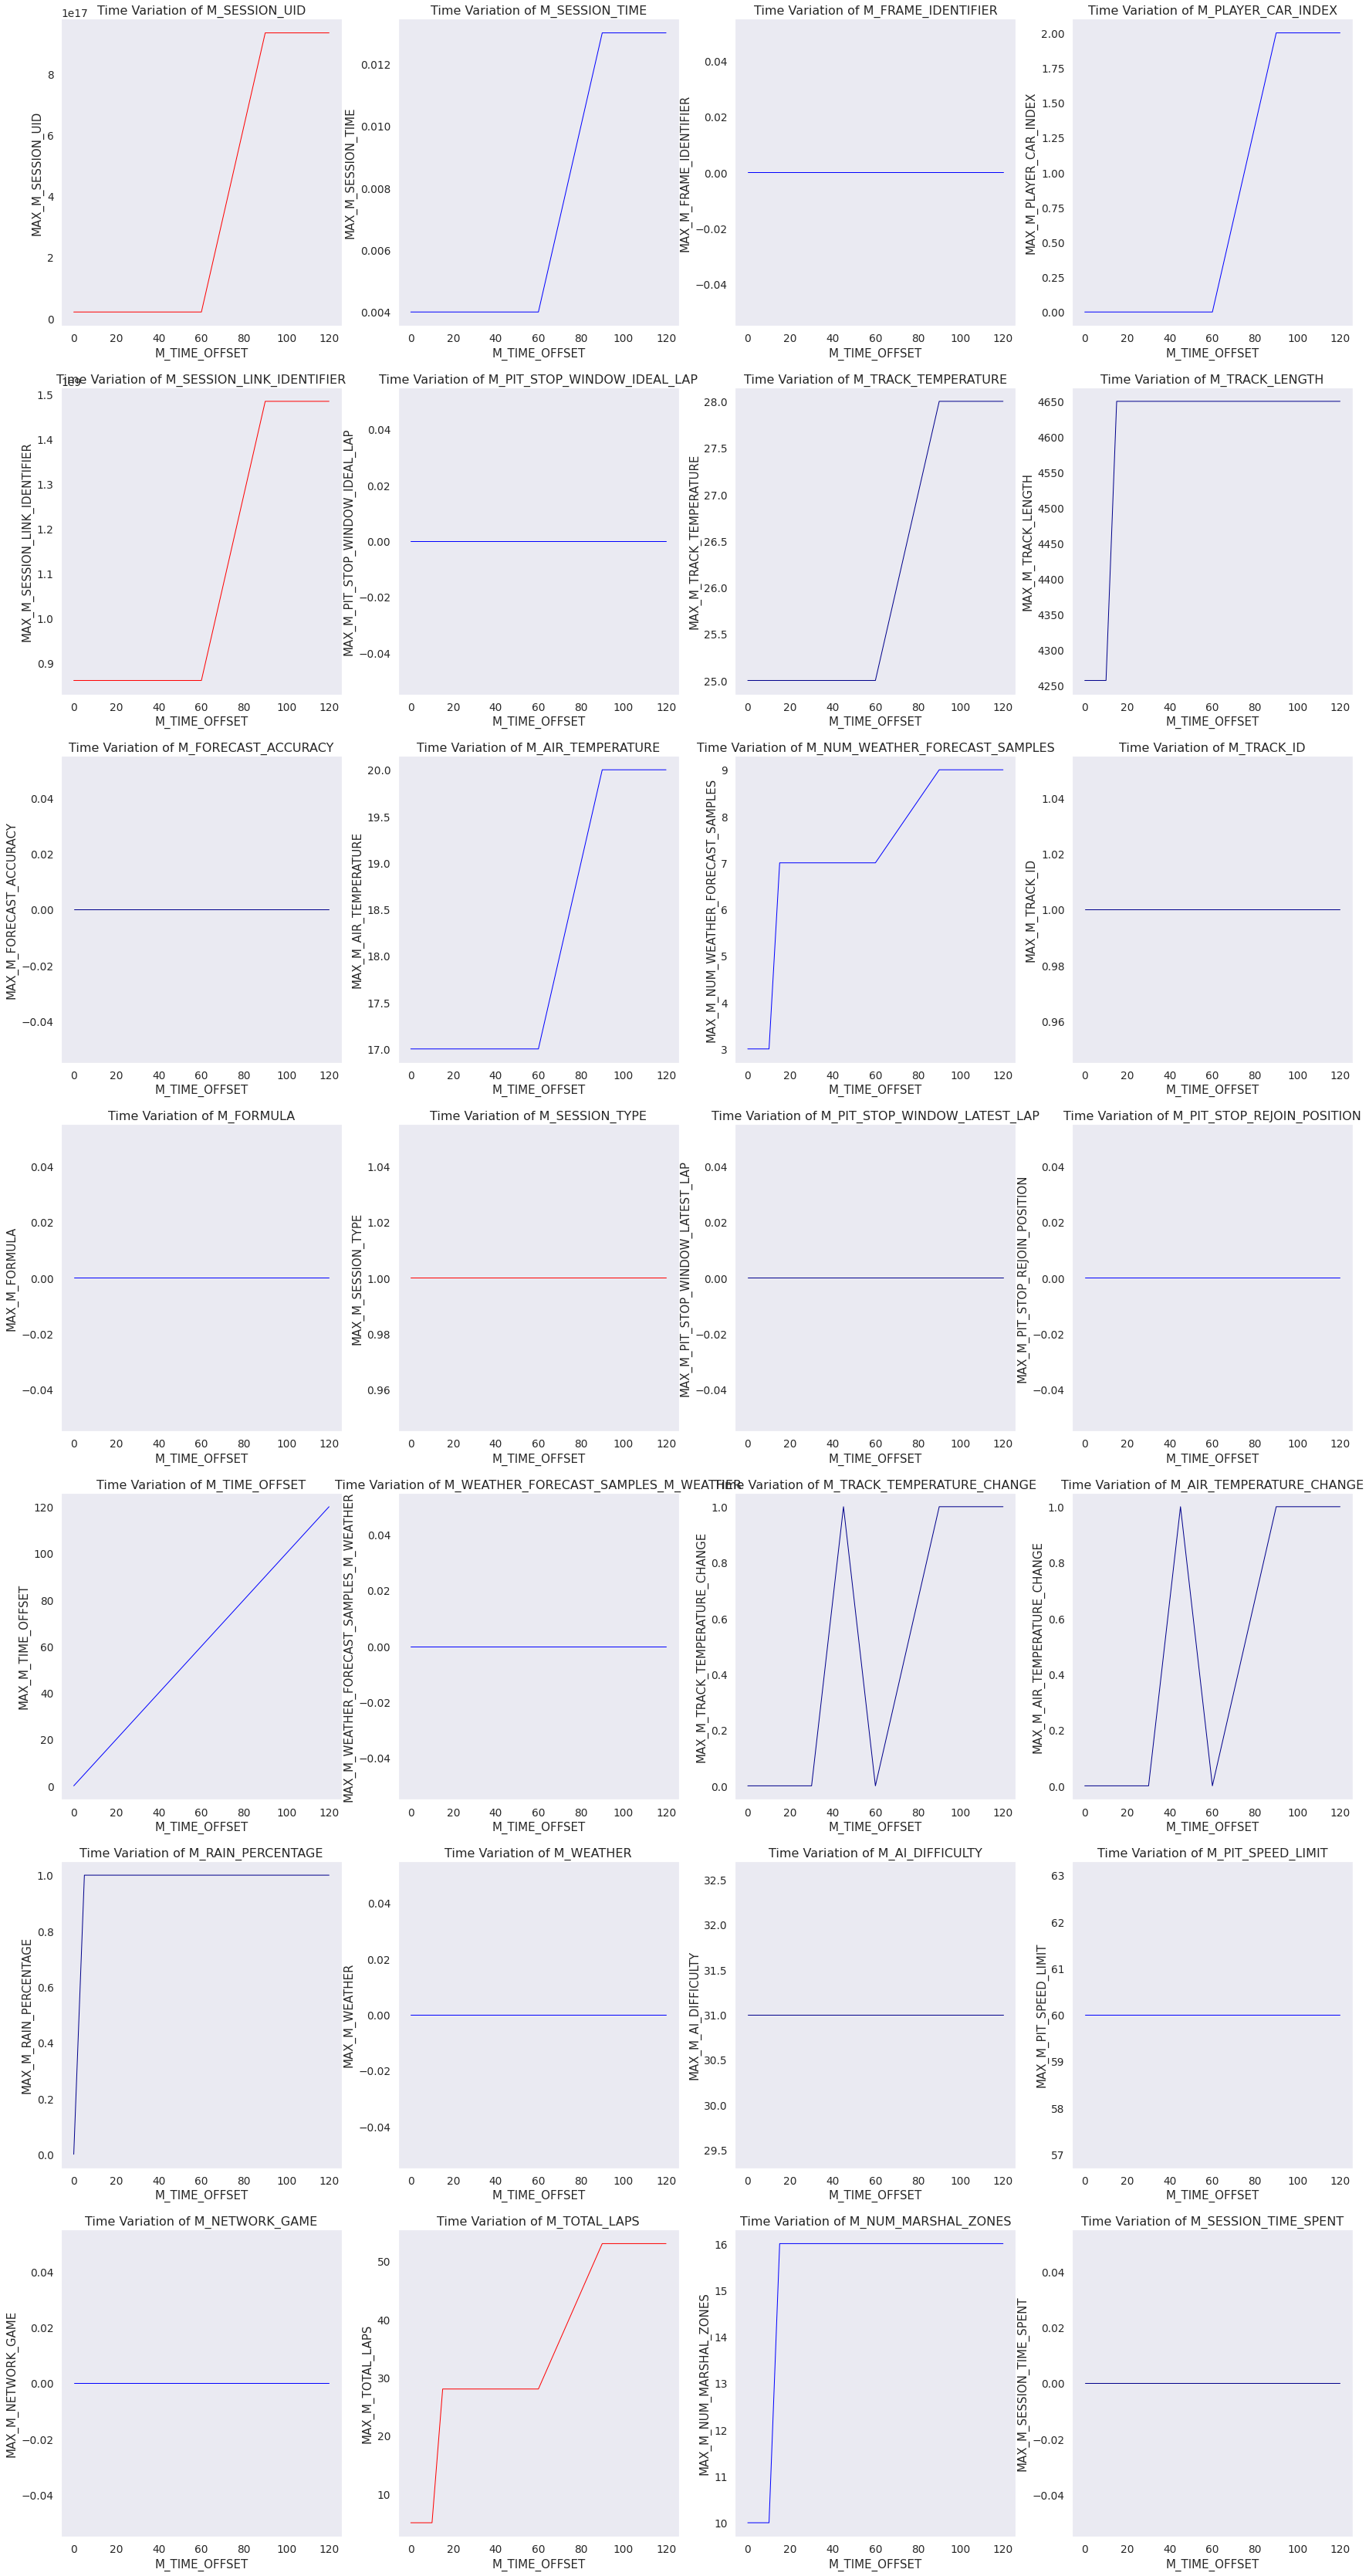

In [53]:
count = 1
colour = 8*['blue','red','darkblue']
plt.figure(figsize=(30,60))
for col in dtime.columns.unique():
    plt.subplot(7,4,count)
    dtime.groupby('M_TIME_OFFSET')[col].min().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('MAX_{}'.format(col)) 
    plt.title('Time Variation of {}'.format(col), fontsize = 16)
    #plt.legend(loc='center')
    plt.grid(False)
    if count<28:
        count+=1

<br>The distributions would have looked different from this had it been we had plotted with the mean since this would have made it more seasonal. However, max or min are more realistic in this case as they allow us detect features that have constant max or min across time offsets. However, it is not clear whether the features that show no variation across time offsets in this plot are binary.

<b>At a glance, we observe the following features are constant in time at min and max:</b><br>
<i>Note, we were careful not to include forecast accuracy, session time spent, and weather forecast sample as we consider these critical to our model regardless of any observations the above distributions present.</i>
- frame ID
- Pit stop window ideal lap
- track id
- formula
- session type
- window latest lap
- pit stop rejoin position
- track temperature change
- AI difficulty
- pit speed limit
- network game

Now, we will isolate these features and study their variations after 5, 10, 15, and 30 minutes. <b>Our final row reduction will be to remove rows with time offset 0, as there's been no indication that these provide any predictive value</b>. This is justfied by the visualisations above which show us constant observations across this time offset.

In [29]:
print('Shape before dropping -->', dtime.shape)
afterdrop = dtime.drop(dtime[dtime['M_TIME_OFFSET']==0.].index)
print('Shape after dropping -->', afterdrop.shape)

Shape before dropping --> (1957078, 28)
Shape after dropping --> (534055, 28)


In [30]:
isolated = afterdrop[[
            'M_SESSION_UID',
            'M_TIME_OFFSET',
            'M_FRAME_IDENTIFIER',
            'M_PIT_STOP_WINDOW_IDEAL_LAP',
            'M_TRACK_LENGTH',
            'M_TRACK_ID',
            'M_FORMULA',
            'M_PIT_STOP_WINDOW_LATEST_LAP',
            'M_PIT_STOP_REJOIN_POSITION',
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_AI_DIFFICULTY',
            'M_PIT_SPEED_LIMIT',
            'M_NETWORK_GAME'
            ]]

Now, we study the variations of these features with respect to time offsets 5, 10, 15, 30.

In [31]:
isolated = isolated[(isolated['M_TIME_OFFSET'] <= 30) & (isolated['M_TIME_OFFSET'] > 0)]
isolated['M_TIME_OFFSET'].unique()

array([ 5., 10., 15., 30.])

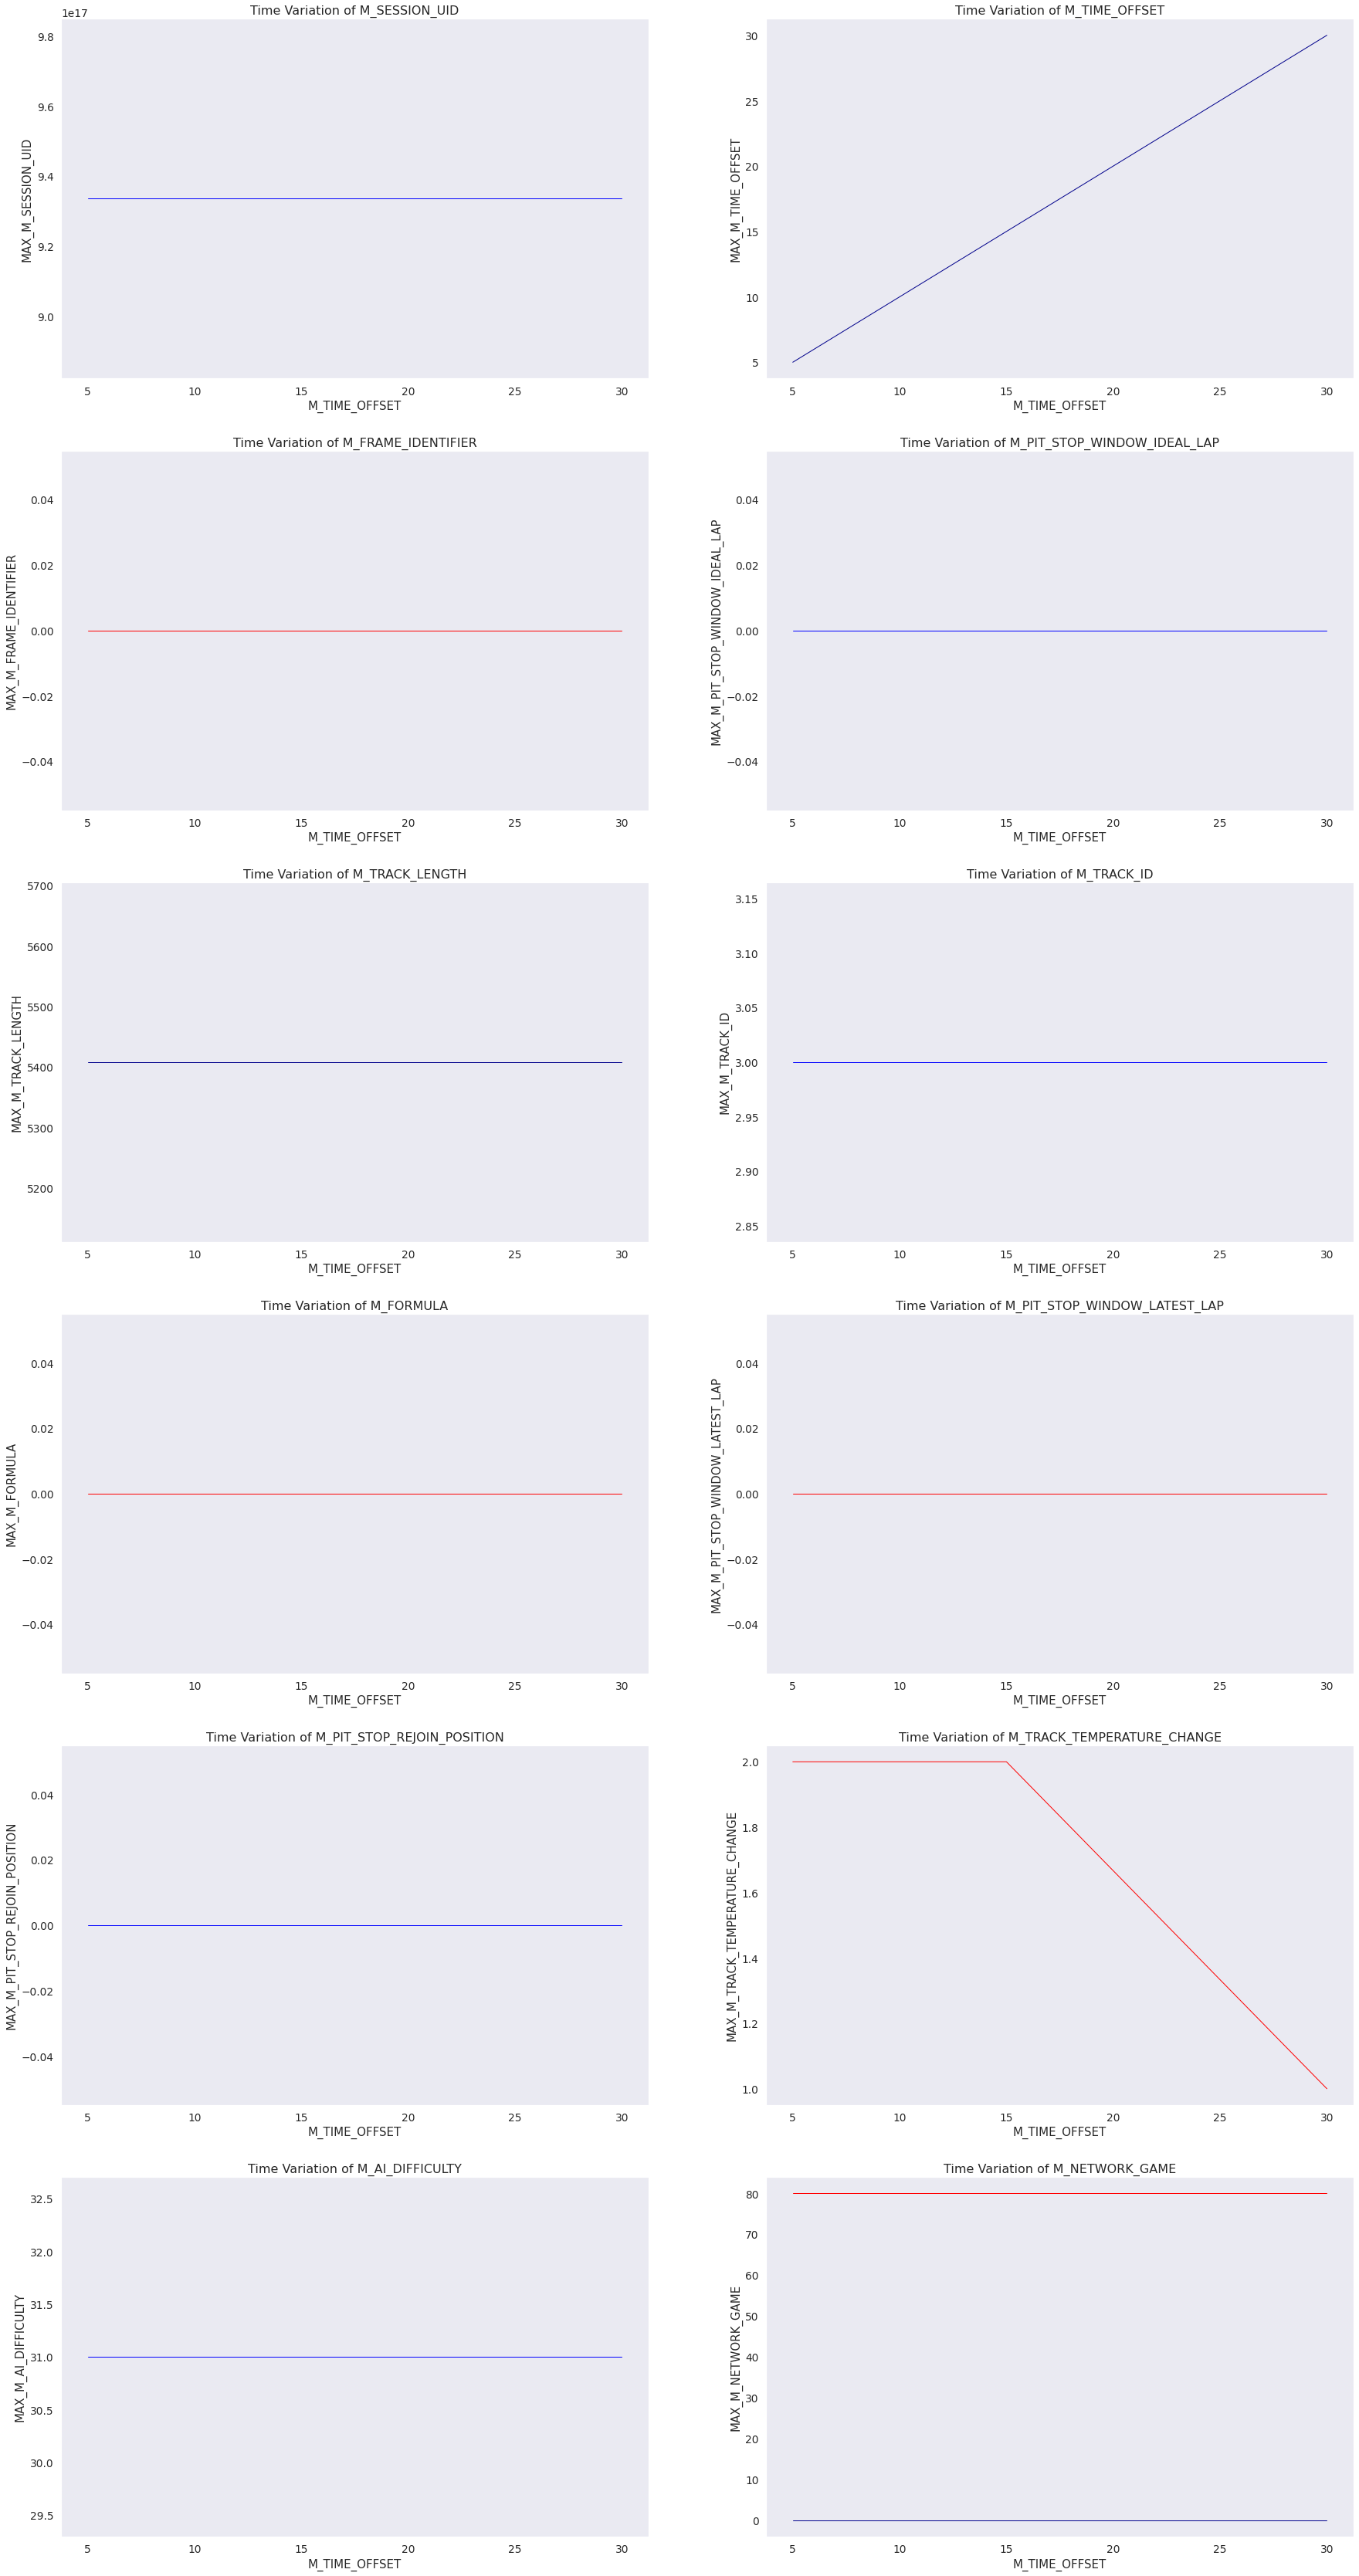

In [97]:
count = 1
colour = ['blue','red','darkblue']
plt.figure(figsize=(30,60))
for col in isolated.columns:
    plt.subplot(6,2,count)
    isolated.groupby('M_TIME_OFFSET')[col].agg(pd.Series.mode).plot(lw=1,color=np.random.choice(colour)) #plotting by mode, implemented by finding the highest value count
    plt.ylabel('MAX_{}'.format(col)) 
    plt.title('Time Variation of {}'.format(col), fontsize = 16)
    #plt.legend(loc='center')
    plt.grid(False)
    if count<12:
        count+=1

<br> We are being careful at this point not to second guess dropping of unwanted features, as many of these features, despite demonstrating no variation in the time offsets, have been shown in our earliest observations to vary session ID by session ID. We will therefore leave the rest of the preprocessing to the next section on feature selection.

In [99]:
#print('Downloading data...')
#afterdrop.to_csv('eda_output.csv')
#print('Done!')

Done!


<br>
<h4><b>2. Feature Selection Experimentations</b></h4>

**(a) Ranking Feature Importance**

We will implement Kepler Variable Importance to rank feature importance for each of our targets:

In [50]:
target1 = afterdrop['M_WEATHER']
target2 = afterdrop['M_RAIN_PERCENTAGE']
features1 = afterdrop.drop('M_WEATHER', axis=1)
features2 = afterdrop.drop('M_RAIN_PERCENTAGE', axis=1)
features2.shape

(534055, 27)

In [54]:
features2.shape

(534055, 27)

<i> **Rank feature importance for Target 1** </i>  🎯

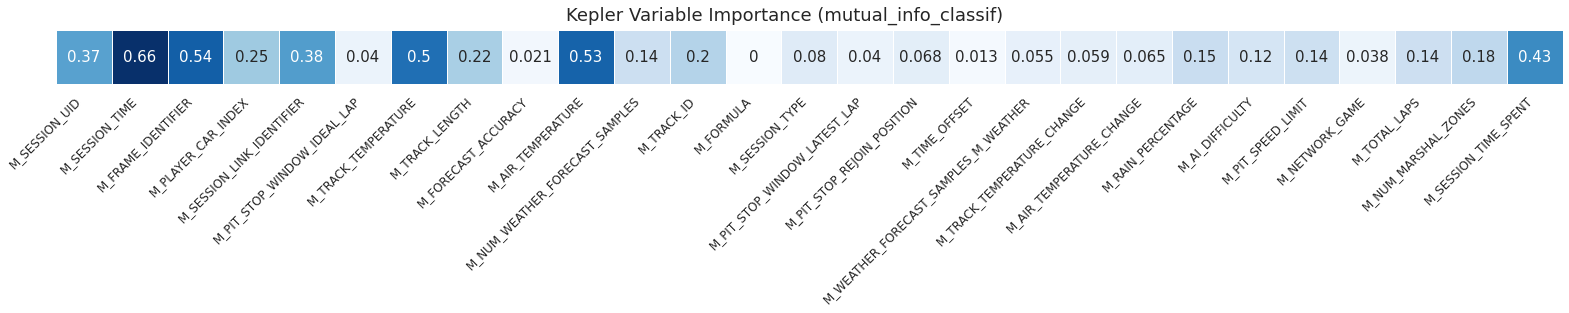

In [56]:
kepler_mutual_information = mutual_info_classif(features1, target1)

plt.subplots(1, figsize=(27, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(features1.columns[0:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

<i> **Rank feature importance for Target 2** </i>  🎯

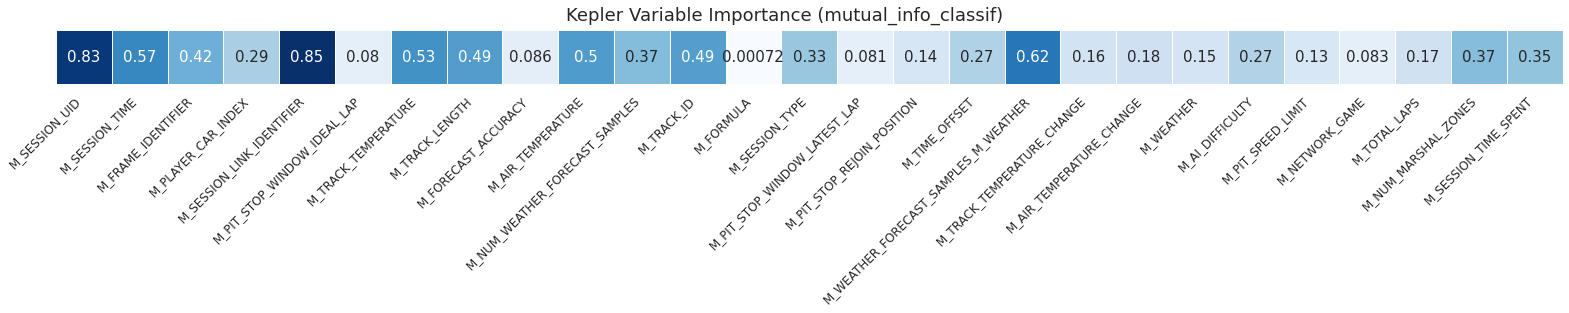

In [57]:
kepler_mutual_information_2 = mutual_info_classif(features2, target2)

plt.subplots(1, figsize=(27, 1))
sns.heatmap(kepler_mutual_information_2[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(features2.columns[0:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

<br> **(b) Feature Selection with Kepler Variable Importance (Generic Univariate Select)**

In [32]:
def feature_selection_table(selected, original_features):
    """
    Display a table that indicates whether or not a feature was selected
    """
    status = []
    index = []
    for col in original_features.columns:
        if col in selected.columns:
            index.append(col)
            status.append('Selected')
        else:
            index.append(col)
            status.append('Not Selected')
            
    _selection_table = pd.DataFrame(status, columns = ['Selection Status'], index = original_features.columns)
    
    print('Number of features selected:', len(selected.columns))
    print('Number of features left out:', len([col for col in original_features.columns if col not in selected.columns]))
    
    return _selection_table

<i> **Select features for target 1** </i>  🎯

In [33]:
#GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode = 'percentile', param=50)
kepler_X_trans = trans.fit_transform(features1, target1)

NameError: name 'features1' is not defined

In [34]:
columns_retained_Select = features1.iloc[:, :].columns[trans.get_support()].values
features_selected_1 = pd.DataFrame(kepler_X_trans, columns=columns_retained_Select)
features_selected_1.shape

NameError: name 'features1' is not defined

In [64]:
feature_selection_table(features_selected_1, features1)

Number of features selected: 13
Number of features left out: 13


Selection Status
M_SESSION_UID                                Selected
M_SESSION_TIME                               Selected
M_FRAME_IDENTIFIER                           Selected
M_PLAYER_CAR_INDEX                           Selected
M_SESSION_LINK_IDENTIFIER                    Selected
M_PIT_STOP_WINDOW_IDEAL_LAP              Not Selected
M_TRACK_TEMPERATURE                          Selected
M_TRACK_LENGTH                               Selected
M_FORECAST_ACCURACY                      Not Selected
M_AIR_TEMPERATURE                            Selected
M_NUM_WEATHER_FORECAST_SAMPLES               Selected
M_TRACK_ID                                   Selected
M_FORMULA                                Not Selected
M_SESSION_TYPE                           Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP             Not Selected
M_PIT_STOP_REJOIN_POSITION               Not Selected
M_TIME_OFFSET                            Not Selected
M_WEATHER_FORECAST_SAMPLES_M_WEATHER     Not Selected
M_TRACK_TEMPERATURE_CHANGE               Not Selected
M_AIR_TEMPERATURE_CHANGE                 Not Selected
M_AI_DIFFICULTY                          Not Selected
M_PIT_SPEED_LIMIT                        Not Selected
M_NETWORK_GAME                           Not Selected
M_TOTAL_LAPS                                 Selected
M_NUM_MARSHAL_ZONES                          Selected
M_SESSION_TIME_SPENT                         Selected

<i> **Select features for target 2** </i>  🎯

In [67]:
#GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
trans_2 = GenericUnivariateSelect(score_func=mutual_info_classif, mode = 'percentile', param=50)
kepler_X_trans_2 = trans_2.fit_transform(features2, target2)

In [68]:
columns_retained_Select_2 = features2.iloc[:, :].columns[trans.get_support()].values
features_selected_2 = pd.DataFrame(kepler_X_trans_2, columns=columns_retained_Select_2)
features_selected_2.shape

(534055, 13)

In [79]:
features_selected_2.columns

Index(['M_SESSION_UID', 'M_SESSION_TIME', 'M_FRAME_IDENTIFIER',
       'M_PLAYER_CAR_INDEX', 'M_SESSION_LINK_IDENTIFIER',
       'M_TRACK_TEMPERATURE', 'M_TRACK_LENGTH', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TRACK_ID', 'M_WEATHER',
       'M_NUM_MARSHAL_ZONES', 'M_SESSION_TIME_SPENT'],
      dtype='object')

In [69]:
feature_selection_table(features_selected_2, features2)

Number of features selected: 13
Number of features left out: 14


Selection Status
M_SESSION_UID                                Selected
M_SESSION_TIME                               Selected
M_FRAME_IDENTIFIER                           Selected
M_PLAYER_CAR_INDEX                           Selected
M_SESSION_LINK_IDENTIFIER                    Selected
M_PIT_STOP_WINDOW_IDEAL_LAP              Not Selected
M_TRACK_TEMPERATURE                          Selected
M_TRACK_LENGTH                               Selected
M_FORECAST_ACCURACY                      Not Selected
M_AIR_TEMPERATURE                            Selected
M_NUM_WEATHER_FORECAST_SAMPLES               Selected
M_TRACK_ID                                   Selected
M_FORMULA                                Not Selected
M_SESSION_TYPE                           Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP             Not Selected
M_PIT_STOP_REJOIN_POSITION               Not Selected
M_TIME_OFFSET                            Not Selected
M_WEATHER_FORECAST_SAMPLES_M_WEATHER     Not Selected
M_TRACK_TEMPERATURE_CHANGE               Not Selected
M_AIR_TEMPERATURE_CHANGE                 Not Selected
M_AI_DIFFICULTY                          Not Selected
M_PIT_SPEED_LIMIT                        Not Selected
M_NETWORK_GAME                           Not Selected
M_TOTAL_LAPS                             Not Selected
M_NUM_MARSHAL_ZONES                          Selected
M_SESSION_TIME_SPENT                         Selected

<br>**(c) Feature Selection with Recursive Feature Elimination**

<i> **Eliminate features for target 1** </i>  🎯

In [46]:
#from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression

In [83]:
selection_model = LogisticRegression(solver='lbfgs')
rfe = RFE(selection_model, n_features_to_select=13, step=1)
fit = rfe.fit(features1, target1)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 13
Selected Features: [False  True  True  True  True False  True  True False  True False  True
 False False False False  True False False False False  True  True False
  True False  True]
Feature Ranking: [15  1  1  1  1  5  1  1 12  1  2  1 14  8  3  7  1 11 10  9  4  1  1 13
  1  6  1]


In [ ]:
feature_selection_table(features_selected_1, features1)

In [81]:
fit.get_feature_names_out(features1.columns)

array(['M_SESSION_TIME', 'M_FRAME_IDENTIFIER', 'M_PLAYER_CAR_INDEX',
       'M_SESSION_LINK_IDENTIFIER', 'M_TRACK_TEMPERATURE',
       'M_TRACK_LENGTH', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TRACK_ID',
       'M_PIT_STOP_WINDOW_LATEST_LAP', 'M_TIME_OFFSET', 'M_AI_DIFFICULTY',
       'M_PIT_SPEED_LIMIT', 'M_TOTAL_LAPS', 'M_SESSION_TIME_SPENT'],
      dtype=object)

In [82]:
features_selected_1.columns

Index(['M_SESSION_UID', 'M_SESSION_TIME', 'M_FRAME_IDENTIFIER',
       'M_PLAYER_CAR_INDEX', 'M_SESSION_LINK_IDENTIFIER',
       'M_TRACK_TEMPERATURE', 'M_TRACK_LENGTH', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TRACK_ID', 'M_TOTAL_LAPS',
       'M_NUM_MARSHAL_ZONES', 'M_SESSION_TIME_SPENT'],
      dtype='object')

In [ ]:
feature_selection_table(features_selected_1, features1)

In [76]:
columns_retained_Select_3 = features1.iloc[:, :].columns[fit.support_].values
features_selected_1 = pd.DataFrame(fit, columns=columns_retained_Select_3)#]
features_selected_1.shape

ValueError: DataFrame constructor not properly called!

<i> **Eliminate features for target 2** </i>  🎯

In [ ]:
selection_model = SVR(kernel="linear")
rfe = RFE(selection_model, n_features_to_select=14, step=1)
fit = rfe.fit(features2, target2)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
fit.get_feature_names_out(features2.columns)

In [ ]:
afterdrop['M_SESSION_UID'].nunique()

In [111]:
for_datarobot = afterdrop.copy()
for_datarobot['SESSION_TIMESTAMP'] = pd.to_datetime(for_datarobot['M_SESSION_TIME'], unit='s')

In [113]:
for_datarobot.set_index('SESSION_TIMESTAMP', inplace = True)

In [115]:
for_datarobot.to_csv('for_datarobot.csv')